# Определение температуры сплава

## Описание проекта

Металлургическому комбинату «Стальная птица» нужно помочь уменьшить количество энергии, которая уходит на нагрев сплава. Для этого было решено находить оптимальную температуру сплава, чтобы расходовалось минимальное количество мощности.  
Заказчик хочет использовать модель, которая будет предсказывать данную температуру, для имитации технологического процесса.  
Саму сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.   
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:  
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).  

Файл data_arc_new.csv
* key — номер партии;
* Начало нагрева дугой — время начала нагрева;
* Конец нагрева дугой — время окончания нагрева;
* Активная мощность — значение активной мощности;
* Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.csv
* key — номер партии;
* Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv  
* key — номер партии;
* Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv
* key — номер партии;
* Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv
* key — номер партии;
* Время замера — время замера;
* Температура — значение температуры.

Файл data_wire_new.csv
* key — номер партии;
* Wire 1 … Wire 9 — объём подаваемых проволочных материалов.

Файл data_wire_time_new.csv
* key — номер партии;
* Wire 1 … Wire 9 — время подачи проволочных материалов.  

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Задача проекта

Найти лучшую модель для предсказания конечной температуры сплава, чтобы уменьшить расходы энергии у металлургического комбината «Стальная птица».

## Установка и импорт библиотек

In [1]:
!pip install -U scikit-learn -q
!pip install phik -q

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

## Используемые функции

In [3]:
# Вывод различной информации о таблице
def analiz(df):
    df.info()
    print()
    display(df.describe())
    print()
    print('Кол-во пропусков в таблице')
    display(df.isna().sum())
    print()
    print('Кол-во дубликатов в таблице')
    display(df.duplicated().sum())
    print()


# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df


# Функция для расчета границ выбросов
def borders(df, column):
    # Рассчитаем первый и третий квантили
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    # Межквартальный размах
    dQ = Q3 - Q1
    # Границы выбросов
    Q1_del = Q1 - dQ * 1.5
    print('Нижняя граница выбросов: ', Q1_del)
    Q3_del = Q3 + dQ * 1.5
    print('Верхняя граница выбросов: ', Q3_del)


## Загрузка данных

Посмотрим на все данные, которые предоставила нам компания, с помощью библиотеки os

In [4]:
datasets = ['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new', 'data_temp_new', 'data_wire_new', 'data_wire_time_new']

for dataset in datasets:
    file_path = f'{dataset}.csv'
    if os.path.exists(file_path):
        print(f'Таблица {dataset}:')
        globals()[dataset] = pd.read_csv(file_path) 
        display(globals()[dataset].head())          
        print('\n\n')
    elif os.path.exists(f'/datasets/{file_path}'):
        print(f'Таблица {dataset}:')
        globals()[dataset] = pd.read_csv(f'/datasets/{file_path}') 
        display(globals()[dataset].head())
        print('\n\n')
    else:
        print('Ошибка чтения файла')

Таблица data_arc_new:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691





Таблица data_bulk_new:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0





Таблица data_bulk_time_new:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47





Таблица data_gas_new:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692





Таблица data_temp_new:


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0





Таблица data_wire_new:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN





Таблица data_wire_time_new:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В общем можно заметить, что названия столбцов написаны на разных языках, но особого смысла переименовывать нет, поэтому их можно только привести к нижнему регистру. Рассмотрим таблицы по отдельности: 
* data_arc_new. Здесь нет ничего особенного на первый взгляд. Все временные данные записаны в точности до секунд. Может быть использован один ключ в нескольких строках.
* data_bulk_new. Для каждой строки свой ключ. Есть очень много пропусков, так как материалы используются далеко не все. Еще можно сделать столбцы с числами целыми
* data_bulk_time_new. Так же как в прошлой таблице уникальные ключи и много пропусков, которые должны соотвествовать датафрейму data_bulk_new.
* data_gas_new. Нет ничего особенного.
* data_temp_new. Ключи дублируются и время точное до секунд. Температуру можно сделать целым типом.
* data_wire_new. Похоже на таблицы про подаваемый материал. Только здесь вместо него используется проволока.
* data_wire_time_new. Соотвествует data_wire_new.

Еще можно будет проверить даты, так как можно удалить год, месяц и возможно даже день, чтобы не было лишней информации

## Исследовательский анализ и предобработка данных

Сразу же приведем названия столбцов к нижнему регистру

In [5]:
datasets_1 = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]
for i in datasets_1:
    i.columns = i.columns.str.lower()

Теперь с помощью функции analiz посмотрим на информации о таблицах

In [6]:
c = 0
datasets_1 = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]
for i in datasets_1:
    c += 1
    print(f'--------------------------------- Таблица {c} ---------------------------------')
    analiz(i)

--------------------------------- Таблица 1 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   начало нагрева дугой  14876 non-null  object 
 2   конец нагрева дугой   14876 non-null  object 
 3   активная мощность     14876 non-null  float64
 4   реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB



,key,активная мощность,реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284



Кол-во пропусков в таблице


key                     0
начало нагрева дугой    0
конец нагрева дугой     0
активная мощность       0
реактивная мощность     0
dtype: int64


Кол-во дубликатов в таблице


0


--------------------------------- Таблица 2 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk 1   252 non-null    float64
 2   bulk 2   22 non-null     float64
 3   bulk 3   1298 non-null   float64
 4   bulk 4   1014 non-null   float64
 5   bulk 5   77 non-null     float64
 6   bulk 6   576 non-null    float64
 7   bulk 7   25 non-null     float64
 8   bulk 8   1 non-null      float64
 9   bulk 9   19 non-null     float64
 10  bulk 10  176 non-null    float64
 11  bulk 11  177 non-null    float64
 12  bulk 12  2450 non-null   float64
 13  bulk 13  18 non-null     float64
 14  bulk 14  2806 non-null   float64
 15  bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB



,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Кол-во пропусков в таблице


key           0
bulk 1     2877
bulk 2     3107
bulk 3     1831
bulk 4     2115
bulk 5     3052
bulk 6     2553
bulk 7     3104
bulk 8     3128
bulk 9     3110
bulk 10    2953
bulk 11    2952
bulk 12     679
bulk 13    3111
bulk 14     323
bulk 15     881
dtype: int64


Кол-во дубликатов в таблице


0


--------------------------------- Таблица 3 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk 1   252 non-null    object
 2   bulk 2   22 non-null     object
 3   bulk 3   1298 non-null   object
 4   bulk 4   1014 non-null   object
 5   bulk 5   77 non-null     object
 6   bulk 6   576 non-null    object
 7   bulk 7   25 non-null     object
 8   bulk 8   1 non-null      object
 9   bulk 9   19 non-null     object
 10  bulk 10  176 non-null    object
 11  bulk 11  177 non-null    object
 12  bulk 12  2450 non-null   object
 13  bulk 13  18 non-null     object
 14  bulk 14  2806 non-null   object
 15  bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Кол-во пропусков в таблице


key           0
bulk 1     2877
bulk 2     3107
bulk 3     1831
bulk 4     2115
bulk 5     3052
bulk 6     2553
bulk 7     3104
bulk 8     3128
bulk 9     3110
bulk 10    2953
bulk 11    2952
bulk 12     679
bulk 13    3111
bulk 14     323
bulk 15     881
dtype: int64


Кол-во дубликатов в таблице


0


--------------------------------- Таблица 4 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB



,key,газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Кол-во пропусков в таблице


key      0
газ 1    0
dtype: int64


Кол-во дубликатов в таблице


0


--------------------------------- Таблица 5 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   время замера  18092 non-null  object 
 2   температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB



,key,температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000



Кол-во пропусков в таблице


key                0
время замера       0
температура     3427
dtype: int64


Кол-во дубликатов в таблице


0


--------------------------------- Таблица 6 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire 1  3055 non-null   float64
 2   wire 2  1079 non-null   float64
 3   wire 3  63 non-null     float64
 4   wire 4  14 non-null     float64
 5   wire 5  1 non-null      float64
 6   wire 6  73 non-null     float64
 7   wire 7  11 non-null     float64
 8   wire 8  19 non-null     float64
 9   wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB



,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Кол-во пропусков в таблице


key          0
wire 1      26
wire 2    2002
wire 3    3018
wire 4    3067
wire 5    3080
wire 6    3008
wire 7    3070
wire 8    3062
wire 9    3052
dtype: int64


Кол-во дубликатов в таблице


0


--------------------------------- Таблица 7 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire 1  3055 non-null   object
 2   wire 2  1079 non-null   object
 3   wire 3  63 non-null     object
 4   wire 4  14 non-null     object
 5   wire 5  1 non-null      object
 6   wire 6  73 non-null     object
 7   wire 7  11 non-null     object
 8   wire 8  19 non-null     object
 9   wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Кол-во пропусков в таблице


key          0
wire 1      26
wire 2    2002
wire 3    3018
wire 4    3067
wire 5    3080
wire 6    3008
wire 7    3070
wire 8    3062
wire 9    3052
dtype: int64


Кол-во дубликатов в таблице


0

Внимательно посмотрев на всю информацию можно сделать выводы, что в некоторых таблицах есть пропуски. Одни можно удалить(температура), а от других будет сложно избавиться, так как они дают информацию, поэтому их в будущем заполним нулями. Есть много аномальных значений, которые заметны по небольшим таблицам про каждый признак, где есть минимальные и максимальные значения по сравнению со средними. От всего этого нужно будет избавиться, но для начала, пока мы не заполнили пропуски, нам нужно построить гистограммы и ящики с усами, чтобы посмотреть на распределения признаков и избиавиться от аномалий. Выбросы не будем удалять, так как заказчик попросил это сделать только в трен выборке, поэтому сделаем это позже. Пару таблиц с датами мы проанализируем потом. Еще можно подметить, что есть материалы, у которых слишком много пропусков и как будто смысла в них особого не будет, но решим это позже.

--------------------------------- Таблица data_arc_new ---------------------------------


<Figure size 864x432 with 0 Axes>

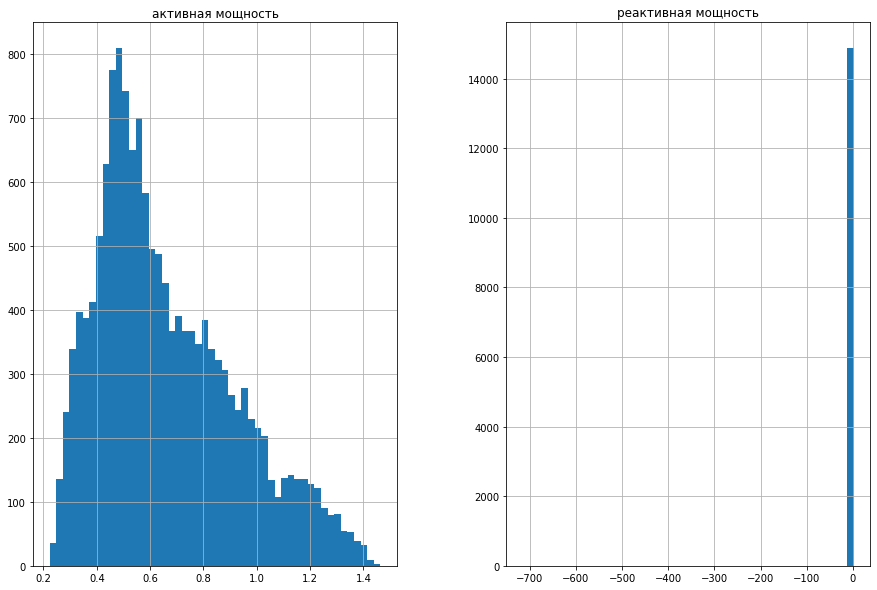

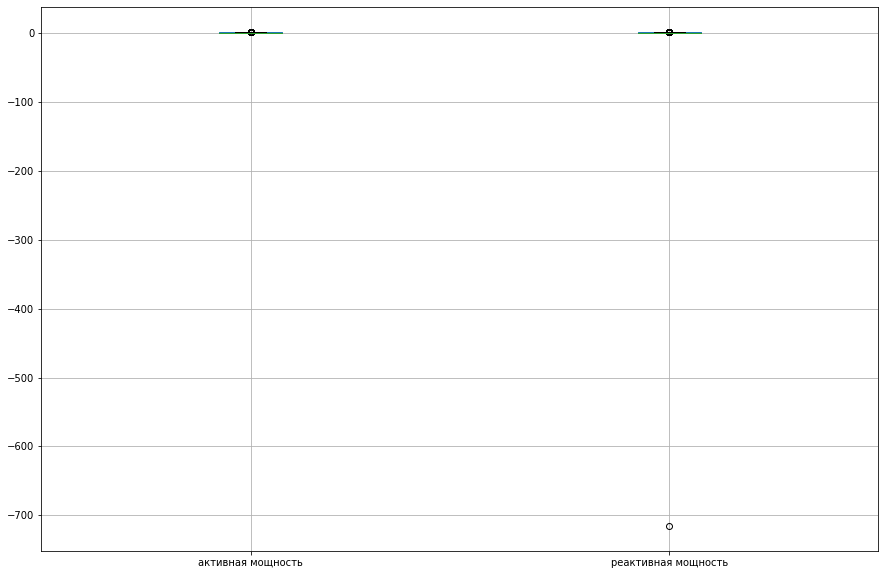

--------------------------------- Таблица data_bulk_new ---------------------------------


<Figure size 864x432 with 0 Axes>

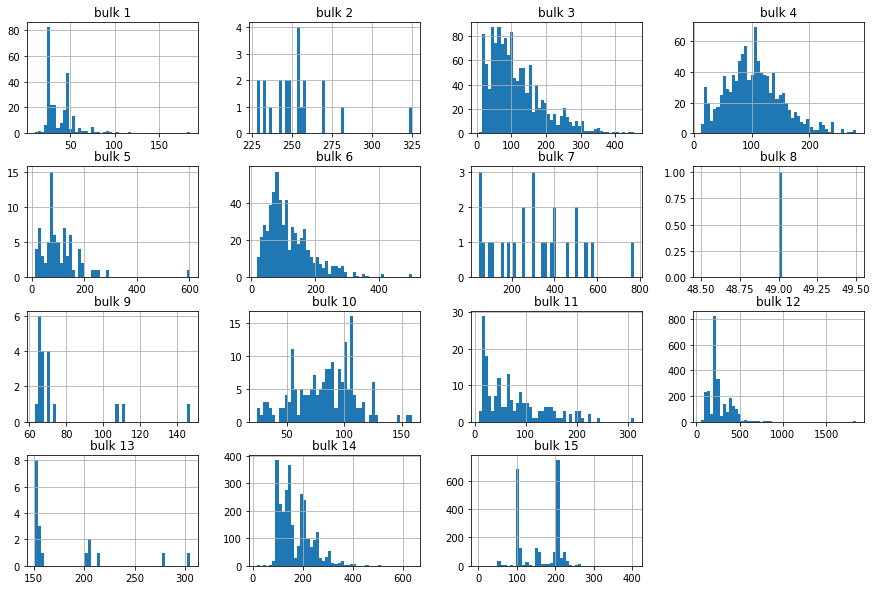

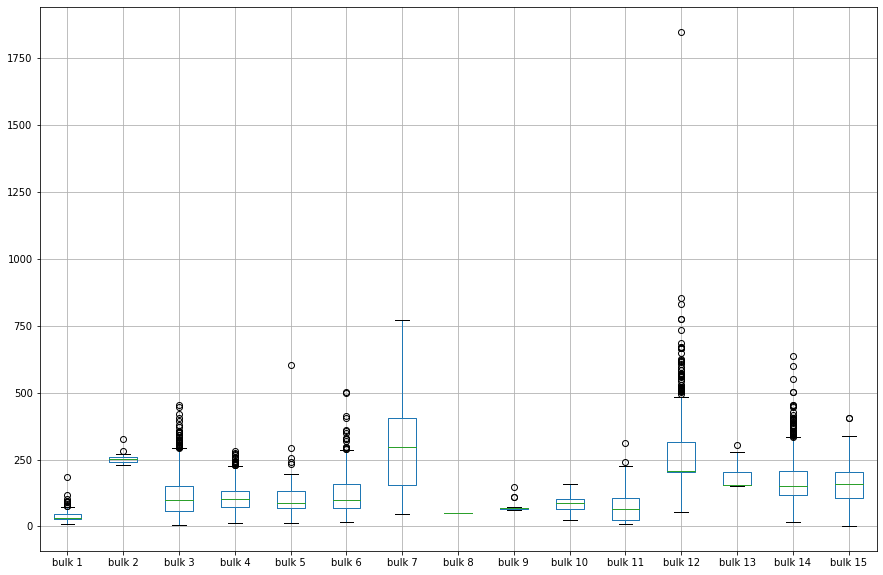

--------------------------------- Таблица data_gas_new ---------------------------------


<Figure size 864x432 with 0 Axes>

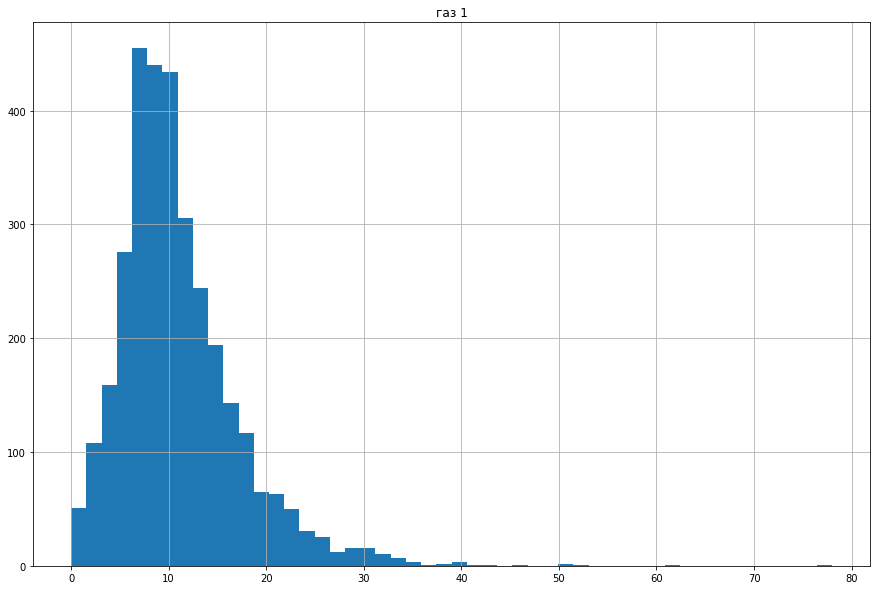

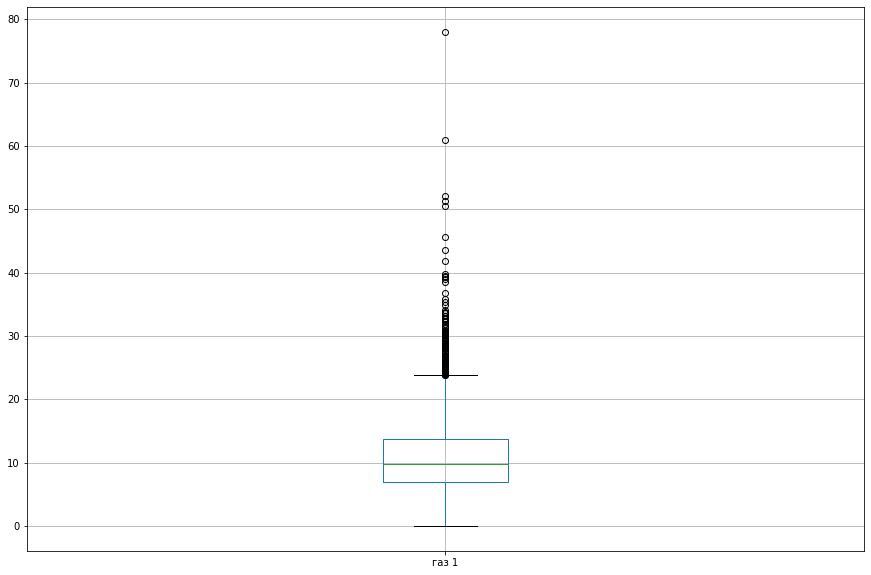

--------------------------------- Таблица data_temp_new ---------------------------------


<Figure size 864x432 with 0 Axes>

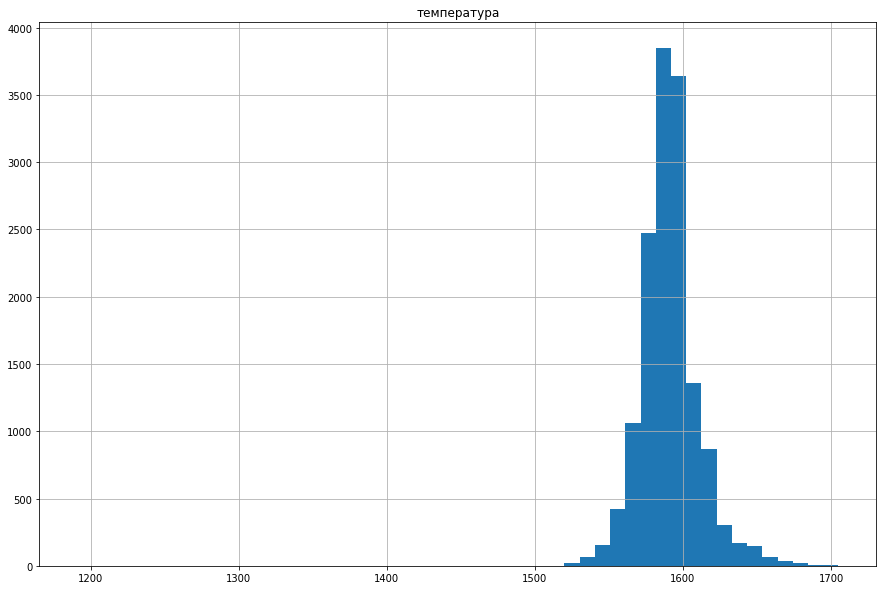

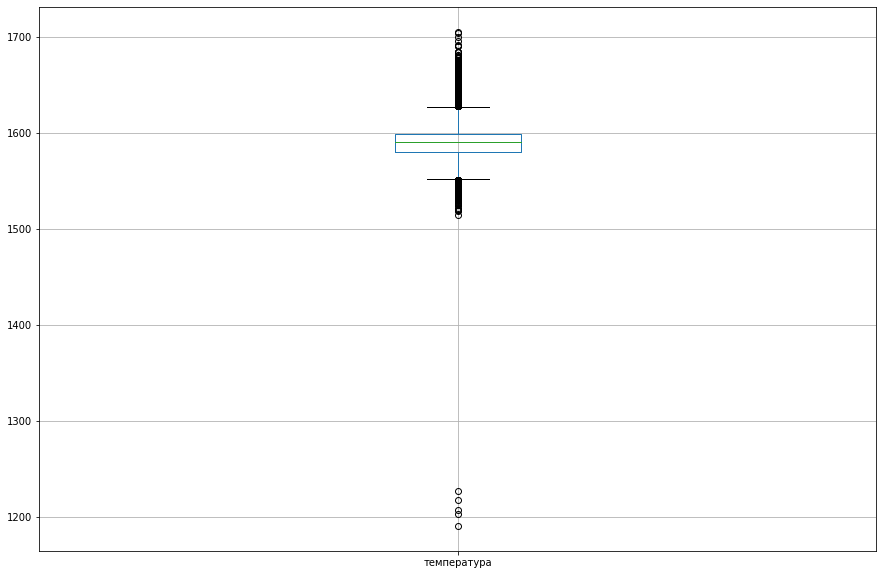

--------------------------------- Таблица data_wire_new ---------------------------------


<Figure size 864x432 with 0 Axes>

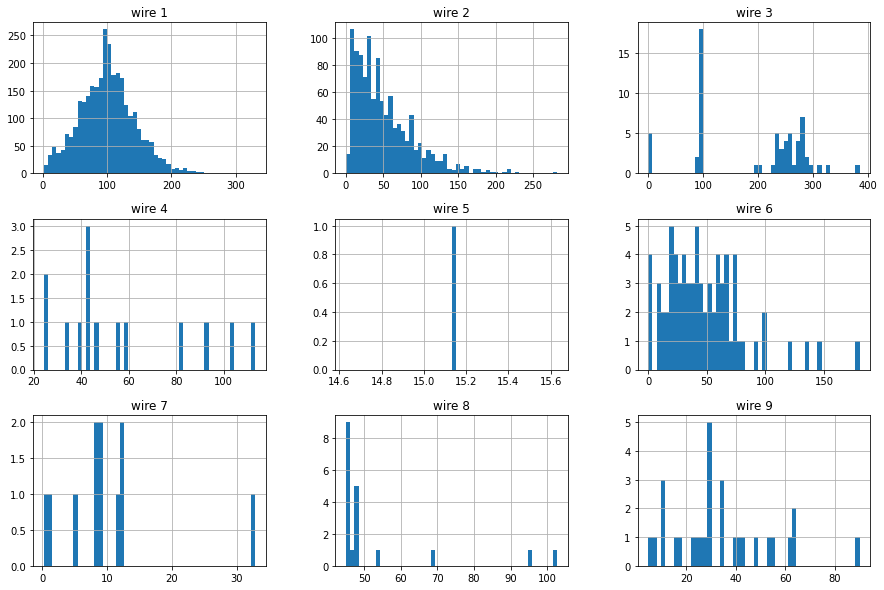

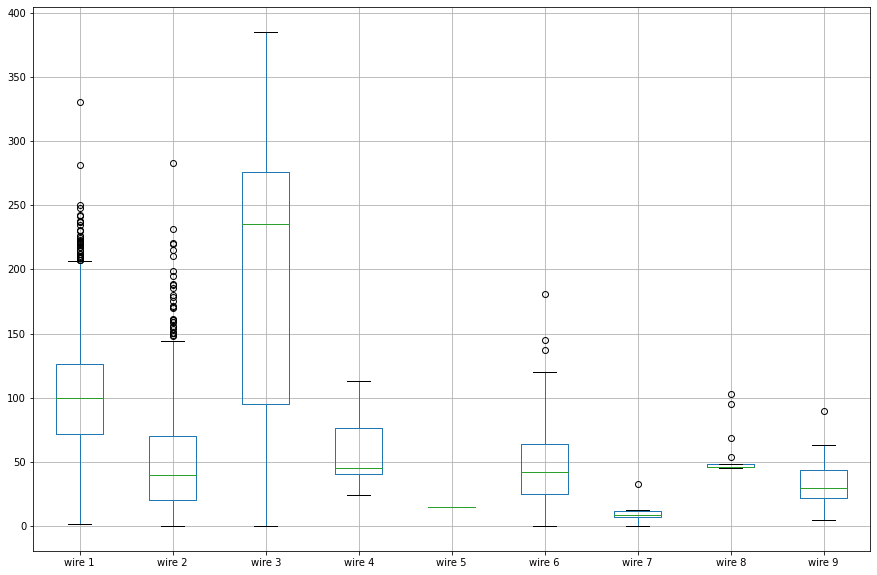

In [7]:
datasets = ['data_arc_new', 'data_bulk_new', 'data_gas_new', 'data_temp_new', 'data_wire_new']
datasets_1 = [data_arc_new, data_bulk_new, data_gas_new, data_temp_new, data_wire_new]

for i in range(len(datasets)):
    datasets_1[i] = datasets_1[i].drop('key', axis=1)
    print(f'--------------------------------- Таблица {datasets[i]} ---------------------------------')
    plt.figure(figsize=(12, 6))

    # Построение гистограммы
    datasets_1[i].hist(figsize=(15, 10), bins = 50)
    plt.show();

    # Построение ящика с усами
    datasets_1[i].boxplot(figsize=(15, 10))
    plt.show();

В таблице data_arc_new активная мощность похожа на Пуассоновское распределение, а вот у реактивной - есть выброс, который портит всю картину. Скорее всего это значение нужно домножить на -10^-3 и тогда все будет хорошо.  
У data_bulk_new можно объяснить такие распределения тем, что это лигирующий металл, поэтому его постоянно добавляли в разных количествах. По ящикам с усами мсожно заметить аномалии. Самая явная это bulk 12. Удалим их все чуть ниже.  
data_gas_new. Тоже похоже на Пуассоновское распределение. Есть выброс, который больше 70. Удалим его и перейдем к следующей таблице.  
У data_temp_new нормальное распределение. По усам можно заметить аномальные выбросы, которые меньше 1300. Удалим их.  
Теперь data_wire_new. Явных аномальных выбросов нет. Не будем ничего делать.  

In [8]:
data_arc_new['реактивная мощность'] = data_arc_new['реактивная мощность'].replace(-715.479924, 0.715479924)
#data_arc_new = data_arc_new[data_arc_new['реактивная мощность'] == -715.479924]
data_arc_new['реактивная мощность'].min()

0.153777

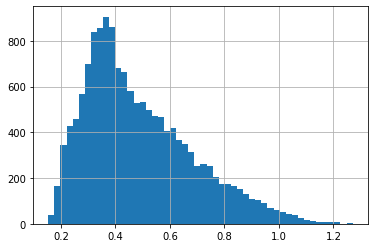

In [9]:
data_arc_new['реактивная мощность'].hist(bins = 50);

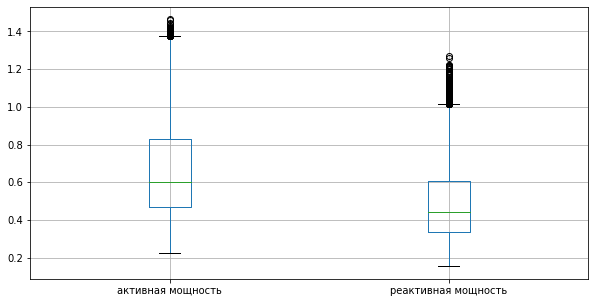

In [10]:
data_arc_new.boxplot(['активная мощность','реактивная мощность'], figsize=(10, 5));

In [11]:
data_temp_new = data_temp_new[data_temp_new['температура'] > 1300]

Переделаем столбцы с датой в тип datetime. Затем преобразуем время в секунды, но только из часом, минут и секунд, чтобы не получилось слишком большое число. Еще сделаем целыми типами нектороые столбцы. Для этого нужно будет заполнить пропуски. Во второй, третьей, шестой и седьмой таблицах вместо None сделаем 0, а с пятой таблицей так не пройдет, так как есть температура, которую не сделать нулем, поэтому просто удалим 3 тысячи пропусков, что не так много для 18 тысяч данных. Оптимизируем все таблицы с помощью функции optimize_memory_usage. Возможно она не поможет всем таблицам, но хоть какой-то вклад внесет.

In [12]:
data_arc_new['начало нагрева дугой'] = pd.to_datetime(data_arc_new['начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc_new['начало нагрева дугой'] = data_arc_new['начало нагрева дугой'].dt.hour * 3600 + data_arc_new['начало нагрева дугой'].dt.minute * 60 + data_arc_new['начало нагрева дугой'].dt.second
data_arc_new['конец нагрева дугой'] = pd.to_datetime(data_arc_new['конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc_new['конец нагрева дугой'] = data_arc_new['конец нагрева дугой'].dt.hour * 3600 + data_arc_new['конец нагрева дугой'].dt.minute * 60 + data_arc_new['конец нагрева дугой'].dt.second
data_temp_new['время замера'] = pd.to_datetime(data_temp_new['время замера'], format='%Y-%m-%d %H:%M:%S')
data_temp_new['время замера'] = data_temp_new['время замера'].dt.hour * 3600 + data_temp_new['время замера'].dt.minute * 60 + data_temp_new['время замера'].dt.second


data_bulk_new = data_bulk_new.fillna(0)
data_bulk_new = data_bulk_new.astype(int)

data_bulk_time_new[data_bulk_time_new.columns[1:]] = data_bulk_time_new[data_bulk_time_new.columns[1:]].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))

for column in data_bulk_time_new.columns[1:]:
    data_bulk_time_new[column] = data_bulk_time_new[column].dt.hour * 3600 + data_bulk_time_new[column].dt.minute * 60 + data_bulk_time_new[column].dt.second
data_bulk_time_new = data_bulk_time_new.fillna(0)
data_bulk_time_new = data_bulk_time_new.astype(int)

data_wire_new = data_wire_new.fillna(0)
data_wire_new = data_wire_new.astype(int)

data_wire_time_new[data_wire_time_new.columns[1:]] = data_wire_time_new[data_wire_time_new.columns[1:]].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))
for column in data_wire_time_new.columns[1:]:
    data_wire_time_new[column] = data_wire_time_new[column].dt.hour * 3600 + data_wire_time_new[column].dt.minute * 60 + data_wire_time_new[column].dt.second
data_wire_time_new = data_wire_time_new.fillna(0)
data_wire_time_new = data_wire_time_new.astype(int)

data_temp_new = data_temp_new.dropna(axis=0)

data_temp_new['температура'] = data_temp_new['температура'].astype(int)

In [13]:
c = 0
datasets_1 = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]
for i in datasets_1:
    c += 1
    print(f'--------------------------------- Таблица {c} ---------------------------------')
    optimize_memory_usage(i)
    print()

--------------------------------- Таблица 1 ---------------------------------
Размер использования памяти: до  0.57 Mb - после  0.26 Mb (55.0%)

--------------------------------- Таблица 2 ---------------------------------
Размер использования памяти: до  0.38 Mb - после  0.09 Mb (75.8%)

--------------------------------- Таблица 3 ---------------------------------
Размер использования памяти: до  0.38 Mb - после  0.19 Mb (51.5%)

--------------------------------- Таблица 4 ---------------------------------
Размер использования памяти: до  0.05 Mb - после  0.02 Mb (62.3%)

--------------------------------- Таблица 5 ---------------------------------
Размер использования памяти: до  0.45 Mb - после  0.22 Mb (50.0%)

--------------------------------- Таблица 6 ---------------------------------
Размер использования памяти: до  0.24 Mb - после  0.04 Mb (81.2%)

--------------------------------- Таблица 7 ---------------------------------
Размер использования памяти: до  0.24 Mb - после  0.

In [14]:
c = 0
datasets_1 = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]
for i in datasets_1:
    c += 1
    print(f'--------------------------------- Таблица {c} ---------------------------------')
    i.info()
    display(i.isna().sum())

--------------------------------- Таблица 1 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int16  
 1   начало нагрева дугой  14876 non-null  int32  
 2   конец нагрева дугой   14876 non-null  int32  
 3   активная мощность     14876 non-null  float32
 4   реактивная мощность   14876 non-null  float32
dtypes: float32(2), int16(1), int32(2)
memory usage: 261.6 KB


key                     0
начало нагрева дугой    0
конец нагрева дугой     0
активная мощность       0
реактивная мощность     0
dtype: int64

--------------------------------- Таблица 2 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int16
 1   bulk 1   3129 non-null   int16
 2   bulk 2   3129 non-null   int16
 3   bulk 3   3129 non-null   int16
 4   bulk 4   3129 non-null   int16
 5   bulk 5   3129 non-null   int16
 6   bulk 6   3129 non-null   int16
 7   bulk 7   3129 non-null   int16
 8   bulk 8   3129 non-null   int8 
 9   bulk 9   3129 non-null   int16
 10  bulk 10  3129 non-null   int16
 11  bulk 11  3129 non-null   int16
 12  bulk 12  3129 non-null   int16
 13  bulk 13  3129 non-null   int16
 14  bulk 14  3129 non-null   int16
 15  bulk 15  3129 non-null   int16
dtypes: int16(15), int8(1)
memory usage: 94.9 KB


key        0
bulk 1     0
bulk 2     0
bulk 3     0
bulk 4     0
bulk 5     0
bulk 6     0
bulk 7     0
bulk 8     0
bulk 9     0
bulk 10    0
bulk 11    0
bulk 12    0
bulk 13    0
bulk 14    0
bulk 15    0
dtype: int64

--------------------------------- Таблица 3 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   key      3129 non-null   int16
 1   bulk 1   3129 non-null   int32
 2   bulk 2   3129 non-null   int32
 3   bulk 3   3129 non-null   int32
 4   bulk 4   3129 non-null   int32
 5   bulk 5   3129 non-null   int32
 6   bulk 6   3129 non-null   int32
 7   bulk 7   3129 non-null   int32
 8   bulk 8   3129 non-null   int32
 9   bulk 9   3129 non-null   int32
 10  bulk 10  3129 non-null   int32
 11  bulk 11  3129 non-null   int32
 12  bulk 12  3129 non-null   int32
 13  bulk 13  3129 non-null   int32
 14  bulk 14  3129 non-null   int32
 15  bulk 15  3129 non-null   int32
dtypes: int16(1), int32(15)
memory usage: 189.6 KB


key        0
bulk 1     0
bulk 2     0
bulk 3     0
bulk 4     0
bulk 5     0
bulk 6     0
bulk 7     0
bulk 8     0
bulk 9     0
bulk 10    0
bulk 11    0
bulk 12    0
bulk 13    0
bulk 14    0
bulk 15    0
dtype: int64

--------------------------------- Таблица 4 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int16  
 1   газ 1   3239 non-null   float32
dtypes: float32(1), int16(1)
memory usage: 19.1 KB


key      0
газ 1    0
dtype: int64

--------------------------------- Таблица 5 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   key           14660 non-null  int16
 1   время замера  14660 non-null  int32
 2   температура   14660 non-null  int16
dtypes: int16(2), int32(1)
memory usage: 229.1 KB


key             0
время замера    0
температура     0
dtype: int64

--------------------------------- Таблица 6 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3081 non-null   int16
 1   wire 1  3081 non-null   int16
 2   wire 2  3081 non-null   int16
 3   wire 3  3081 non-null   int16
 4   wire 4  3081 non-null   int8 
 5   wire 5  3081 non-null   int8 
 6   wire 6  3081 non-null   int16
 7   wire 7  3081 non-null   int8 
 8   wire 8  3081 non-null   int8 
 9   wire 9  3081 non-null   int8 
dtypes: int16(5), int8(5)
memory usage: 45.3 KB


key       0
wire 1    0
wire 2    0
wire 3    0
wire 4    0
wire 5    0
wire 6    0
wire 7    0
wire 8    0
wire 9    0
dtype: int64

--------------------------------- Таблица 7 ---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   key     3081 non-null   int16
 1   wire 1  3081 non-null   int32
 2   wire 2  3081 non-null   int32
 3   wire 3  3081 non-null   int32
 4   wire 4  3081 non-null   int32
 5   wire 5  3081 non-null   int16
 6   wire 6  3081 non-null   int32
 7   wire 7  3081 non-null   int32
 8   wire 8  3081 non-null   int32
 9   wire 9  3081 non-null   int32
dtypes: int16(2), int32(8)
memory usage: 108.4 KB


key       0
wire 1    0
wire 2    0
wire 3    0
wire 4    0
wire 5    0
wire 6    0
wire 7    0
wire 8    0
wire 9    0
dtype: int64

В данной части шага мы проделали достаточно большую работу, так как таблиц было много и ситуации у них разные:  
* В data_arc_new "начало нагрева дугой" и "конец нагрева дугой" мы перевели время в секунды. Оптимизировали данные на 44%
* data_bulk_new. Пропуски у объёма подаваемого материала заполнили 0. Уменьшили объем данных на целых 52%
* У data_bulk_time_new время подачи материала перевели в секунды и целый тип, а пропуски заменили 0. Оптимизировали данные всего на 3%
* data_gas_new сделали только оптимизацию на 62%
* В data_temp_new.csv время замера перевели в секунды, температуру перевели в целый тип. Уменьшили объем данных на целых 33%
* data_wire_new. Сделали типы данных целыми. Оптимизировали данные на 62%
* У data_wire_time_new столбцы перевели в секунды. Уменьшили объем данных на целых 10%

In [15]:
datasets_1 = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]
datasets = ['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new', 'data_temp_new', 'data_wire_new', 'data_wire_time_new']
for i in range (7):
    print(f'--------------------------------- Таблица {datasets[i]} ---------------------------------')
    display(datasets_1[i].head())

--------------------------------- Таблица data_arc_new ---------------------------------


,key,начало нагрева дугой,конец нагрева дугой,активная мощность,реактивная мощность
0,1,39734,39962,0.305130,0.211253
1,1,40048,40233,0.765658,0.477438
2,1,40304,40476,0.580313,0.430460
3,1,40694,41059,0.518496,0.379979
4,1,41169,41317,0.867133,0.643691


--------------------------------- Таблица data_bulk_new ---------------------------------


,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
0,1,0,0,0,43,0,0,0,0,0,0,0,206,0,150,154
1,2,0,0,0,73,0,0,0,0,0,0,0,206,0,149,154
2,3,0,0,0,34,0,0,0,0,0,0,0,205,0,152,153
3,4,0,0,0,81,0,0,0,0,0,0,0,207,0,153,154
4,5,0,0,0,78,0,0,0,0,0,0,0,203,0,151,152


--------------------------------- Таблица data_bulk_time_new ---------------------------------


,key,bulk 1,bulk 2,bulk 3,bulk 4,bulk 5,bulk 6,bulk 7,bulk 8,bulk 9,bulk 10,bulk 11,bulk 12,bulk 13,bulk 14,bulk 15
0,1,0,0,0,41328,0,0,0,0,0,0,0,41071,0,40490,40243
1,2,0,0,0,41810,0,0,0,0,0,0,0,42810,0,42517,42279
2,3,0,0,0,45159,0,0,0,0,0,0,0,44833,0,44461,44176
3,4,0,0,0,45802,0,0,0,0,0,0,0,46680,0,46271,45996
4,5,0,0,0,48647,0,0,0,0,0,0,0,48647,0,48852,48647


--------------------------------- Таблица data_gas_new ---------------------------------


,key,газ 1
0,1,29.749987
1,2,12.555561
2,3,28.554792
3,4,18.841219
4,5,5.413692


--------------------------------- Таблица data_temp_new ---------------------------------


,key,время замера,температура
0,1,39724,1571
1,1,40038,1604
2,1,40294,1618
3,1,40684,1601
4,1,41159,1606


--------------------------------- Таблица data_wire_new ---------------------------------


,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,60,0,0,0,0,0,0,0,0
1,2,96,0,0,0,0,0,0,0,0
2,3,91,0,0,0,0,0,0,0,0
3,4,89,0,0,0,0,0,0,0,0
4,5,89,9,0,0,0,0,0,0,0


--------------------------------- Таблица data_wire_time_new ---------------------------------


,key,wire 1,wire 2,wire 3,wire 4,wire 5,wire 6,wire 7,wire 8,wire 9
0,1,39979,0,0,0,0,0,0,0,0
1,2,41810,0,0,0,0,0,0,0,0
2,3,43906,0,0,0,0,0,0,0,0
3,4,45802,0,0,0,0,0,0,0,0
4,5,48044,47734,0,0,0,0,0,0,0


После анализа данных можно сделать небольшие выводы про них. Если мы добавим новые столбцы с разницей времени конца и начала нагрева и обновленным признаком замера времени от начала нагрева, то нам не будут нужны такие большие числа и мы сможем удалить эти столбцы, так как от определенного времени не будет ничего зависеть. Активная и реактивная мощности скорее всего понадобятся, но и с их помощью можно будет создать новый признак с общей мощностью. У объёма подаваемого материала не все параметры оказались сильно задействованы. Например, bulk 8 имеет всего 1 заполненное значение, что слишком мало для обучения. Тоже самое можно сказать и про булк 2, 5, 7, 9, 13. У проволоки тоже такая ситуация с 3 по 9. Но с этим ничего не поделать, так как эти признаки могут быть использованы в будущем.

## Объединение таблиц

На данном этапе нам нужно объединить все наши таблицы. Для этого воспользуемся методом merge. Нам нужно получить один датафрейм, состоящий из уникальных ключей. В data_arc_new и data_temp_new ключи повторяются, поэтому возьмем у них где-то только максимальные, а где-то минимальные или суммы всех значений. После этого можно будет их объединить. Еще надо будет в data_temp_new отобрать только те ключи, которые встречаются в ней больше одного
раза

In [16]:
# оставляем уникальные ключи в data_arc_new 
data_arc_new_1 = data_arc_new.groupby('key').agg({
    'начало нагрева дугой': 'min',
    'конец нагрева дугой': 'max',
    'активная мощность': 'sum',
    'реактивная мощность': 'sum'
}).reset_index()

display(data_arc_new_1.head())

,key,начало нагрева дугой,конец нагрева дугой,активная мощность,реактивная мощность
0,1,39734,41317,3.036730,2.142821
1,2,41654,42798,2.139408,1.453357
2,3,43614,45139,4.063641,2.937457
3,4,45577,46670,2.706489,2.056992
4,5,47473,48835,2.252950,1.687991


In [17]:
# отбираем у data_temp_new только те ключи, которые встретились больше одного раза
key_counts = data_temp_new['key'].value_counts()
keys_to_keep = key_counts[key_counts > 1].index
data_temp_new_0 = data_temp_new[data_temp_new['key'].isin(keys_to_keep)]
data_temp_new_0.head()

,key,время замера,температура
0,1,39724,1571
1,1,40038,1604
2,1,40294,1618
3,1,40684,1601
4,1,41159,1606


In [18]:
# в data_temp_new_0 оставляем только первые температуры, т.е. начальные
data_temp_new_2 = data_temp_new_0.drop_duplicates('key', keep='first').reset_index(drop=True)
data_temp_new_2.columns = ['key', 'первый замер', 'начальная температура']
data_temp_new_2 = data_temp_new_2.drop('первый замер', axis = 1)
display(data_temp_new_2.head())

,key,начальная температура
0,1,1571
1,2,1581
2,3,1596
3,4,1601
4,5,1576


In [19]:
# тут в data_temp_new_0 отбираем целевой признак и его время замера
data_temp_new_1 = data_temp_new_0.drop_duplicates('key', keep='last').reset_index(drop=True)
display(data_temp_new_1.head())

,key,время замера,температура
0,1,41438,1613
1,2,42909,1602
2,3,45357,1599
3,4,46787,1625
4,5,48999,1602


In [20]:
# объединяем таблички по inner
data = data_arc_new_1.merge(data_bulk_new, on = 'key', how = 'inner')
data = data.merge(data_bulk_time_new, on = 'key', how = 'inner')
data = data.merge(data_gas_new, on = 'key', how = 'inner')
data = data.merge(data_temp_new_2, on = 'key', how = 'inner')
data = data.merge(data_temp_new_1, on = 'key', how = 'inner')
data = data.merge(data_wire_new, on = 'key', how = 'inner')
data = data.merge(data_wire_time_new, on = 'key', how = 'inner')
data

,key,начало нагрева дугой,конец нагрева дугой,активная мощность,реактивная мощность,bulk 1_x,bulk 2_x,bulk 3_x,bulk 4_x,bulk 5_x,...,wire 9_x,wire 1_y,wire 2_y,wire 3_y,wire 4_y,wire 5_y,wire 6_y,wire 7_y,wire 8_y,wire 9_y
0,1,39734,41317,3.036730,2.142821,0,0,0,43,0,...,0,39979,0,0,0,0,0,0,0,0
1,2,41654,42798,2.139408,1.453357,0,0,0,73,0,...,0,41810,0,0,0,0,0,0,0,0
2,3,43614,45139,4.063641,2.937457,0,0,0,34,0,...,0,43906,0,0,0,0,0,0,0,0
3,4,45577,46670,2.706489,2.056992,0,0,0,81,0,...,0,45802,0,0,0,0,0,0,0,0
4,5,47473,48835,2.252950,1.687991,0,0,0,78,0,...,0,48044,47734,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,41277,42485,3.168133,2.210936,0,0,21,0,0,...,0,41500,0,0,0,0,0,0,0,0
2325,2496,43018,44587,4.174918,2.872031,0,0,0,63,0,...,0,43150,0,0,0,0,0,0,0,0
2326,2497,45456,46280,3.605239,2.452092,0,0,0,85,0,...,0,45970,45630,0,0,0,0,0,0,0
2327,2498,46701,48059,3.202310,2.239820,0,0,90,0,0,...,0,46974,0,0,0,0,0,0,0,0


Получилась огромная таблица 3020 строк и 58 столбцов. 

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2329 non-null   int64  
 1   начало нагрева дугой   2329 non-null   int32  
 2   конец нагрева дугой    2329 non-null   int32  
 3   активная мощность      2329 non-null   float32
 4   реактивная мощность    2329 non-null   float32
 5   bulk 1_x               2329 non-null   int16  
 6   bulk 2_x               2329 non-null   int16  
 7   bulk 3_x               2329 non-null   int16  
 8   bulk 4_x               2329 non-null   int16  
 9   bulk 5_x               2329 non-null   int16  
 10  bulk 6_x               2329 non-null   int16  
 11  bulk 7_x               2329 non-null   int16  
 12  bulk 8_x               2329 non-null   int8   
 13  bulk 9_x               2329 non-null   int16  
 14  bulk 10_x              2329 non-null   int16  
 15  bulk

bulk и wire с припиской у означает, что это столбец с секундами. С помощью разницы между bulk_у и начало нагрева дугой можно получить время, которое прошло с начала нагрева, то есть не понадобится столбик о начале. Еще найдем длительность нагрева это разница между концом и началом.

In [22]:
# добавляем новые признаки и удаляем не нужные
data['длительность нагрева'] = data['конец нагрева дугой'] - data['начало нагрева дугой']

selected_columns = data.columns[20:35]
data[selected_columns] = data[selected_columns].sub(data['начало нагрева дугой'], axis=0)
data.iloc[:, 20:35] = data.iloc[:, 20:35].mask(data.iloc[:, 20:35] < 0, 0)

selected_columns = data.columns[48:57]
data[selected_columns] = data[selected_columns].sub(data['начало нагрева дугой'], axis=0)
data.iloc[:, 48:57] = data.iloc[:, 48:57].mask(data.iloc[:, 48:57] < 0, 0)

data['время замера'] = data['время замера'] - data['начало нагрева дугой']
data = data.drop(['начало нагрева дугой', 'конец нагрева дугой'], axis = 1)
data['полная мощность'] = (data['активная мощность']**2 + data['реактивная мощность']**2)**0.5
data

,key,активная мощность,реактивная мощность,bulk 1_x,bulk 2_x,bulk 3_x,bulk 4_x,bulk 5_x,bulk 6_x,bulk 7_x,...,wire 2_y,wire 3_y,wire 4_y,wire 5_y,wire 6_y,wire 7_y,wire 8_y,wire 9_y,длительность нагрева,полная мощность
0,1,3.036730,2.142821,0,0,0,43,0,0,0,...,0,0,0,0,0,0,0,0,1583,3.716640
1,2,2.139408,1.453357,0,0,0,73,0,0,0,...,0,0,0,0,0,0,0,0,1144,2.586370
2,3,4.063641,2.937457,0,0,0,34,0,0,0,...,0,0,0,0,0,0,0,0,1525,5.014163
3,4,2.706489,2.056992,0,0,0,81,0,0,0,...,0,0,0,0,0,0,0,0,1093,3.399456
4,5,2.252950,1.687991,0,0,0,78,0,0,0,...,261,0,0,0,0,0,0,0,1362,2.815155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,3.168133,2.210936,0,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,1208,3.863328
2325,2496,4.174918,2.872031,0,0,0,63,0,0,0,...,0,0,0,0,0,0,0,0,1569,5.067396
2326,2497,3.605239,2.452092,0,0,0,85,0,0,0,...,174,0,0,0,0,0,0,0,824,4.360104
2327,2498,3.202310,2.239820,0,0,90,0,0,0,0,...,0,0,0,0,0,0,0,0,1358,3.907887


Вроде все сделали. Проверим что получилось с помощью знакомой функции analiz()

In [23]:
analiz(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2329 non-null   int64  
 1   активная мощность      2329 non-null   float32
 2   реактивная мощность    2329 non-null   float32
 3   bulk 1_x               2329 non-null   int16  
 4   bulk 2_x               2329 non-null   int16  
 5   bulk 3_x               2329 non-null   int16  
 6   bulk 4_x               2329 non-null   int16  
 7   bulk 5_x               2329 non-null   int16  
 8   bulk 6_x               2329 non-null   int16  
 9   bulk 7_x               2329 non-null   int16  
 10  bulk 8_x               2329 non-null   int8   
 11  bulk 9_x               2329 non-null   int16  
 12  bulk 10_x              2329 non-null   int16  
 13  bulk 11_x              2329 non-null   int16  
 14  bulk 12_x              2329 non-null   int16  
 15  bulk

,key,активная мощность,реактивная мощность,bulk 1_x,bulk 2_x,bulk 3_x,bulk 4_x,bulk 5_x,bulk 6_x,bulk 7_x,...,wire 2_y,wire 3_y,wire 4_y,wire 5_y,wire 6_y,wire 7_y,wire 8_y,wire 9_y,длительность нагрева,полная мощность
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,3.125336,2.300829,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,2.004723,...,646.613139,56.893946,45.976385,0.0,80.647918,4.894805,1.689996,2.360240,3662.432374,3.881929
std,714.762400,1.220799,0.903823,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,30.676234,...,6589.400868,1691.943871,1664.047846,0.0,2409.998560,226.734700,28.640683,30.651592,11842.962760,1.516380
min,1.000000,0.267676,0.196228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,57.000000,0.331897
25%,630.000000,2.295820,1.670519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1325.000000,2.841650
50%,1255.000000,3.035365,2.226403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1750.000000,3.767064
75%,1868.000000,3.834300,2.829159,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,...,146.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2434.000000,4.767256
max,2499.000000,12.375636,8.949049,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,...,86180.000000,80223.000000,79261.000000,0.0,85484.000000,10939.000000,989.000000,1019.000000,86305.000000,15.272258



Кол-во пропусков в таблице


key                      0
активная мощность        0
реактивная мощность      0
bulk 1_x                 0
bulk 2_x                 0
bulk 3_x                 0
bulk 4_x                 0
bulk 5_x                 0
bulk 6_x                 0
bulk 7_x                 0
bulk 8_x                 0
bulk 9_x                 0
bulk 10_x                0
bulk 11_x                0
bulk 12_x                0
bulk 13_x                0
bulk 14_x                0
bulk 15_x                0
bulk 1_y                 0
bulk 2_y                 0
bulk 3_y                 0
bulk 4_y                 0
bulk 5_y                 0
bulk 6_y                 0
bulk 7_y                 0
bulk 8_y                 0
bulk 9_y                 0
bulk 10_y                0
bulk 11_y                0
bulk 12_y                0
bulk 13_y                0
bulk 14_y                0
bulk 15_y                0
газ 1                    0
начальная температура    0
время замера             0
температура              0
w


Кол-во дубликатов в таблице


0

Все отлично! Нет ни одного пропуска, нужные признаки на месте

На данном шаге мы объединили все датафреймы в один. Затем изменили некоторые признаки, добавили новые и удалили не нужные. Все временные столбцы изменили на разницу с началом замеров, так как данные признаки будут полезнее и информативнее. С помощью активной и реактивной мощностей создали полную мощность из корня квадратов суммы этих мощностей, которая может с ними сильно коррелировать, но это не страшно, так как его всегда можно будет удалить. Важным действием было удаление партий, где температуру измеряли всего один раз, так как на них модель не сможет обучиться.

## Анализ и предобработка данных общего датафрейма

На данном шаге планируем исследовать данные на выбросы, которые нужно будет удалить только для тренировочной выборки, и сделаем корреляционный анализ, чтобы узнать о взаимосвязях всех наших признаков. У нас 56 признаков, которые нужно проверить, поэтому в корреляционном анализе нельзя будет рассмотерть сразу все признаки, так как их слишком много

Для анализа выбросов нужно заполнить нули в bulr wire пропусками, чтобы они не забирали на себя значения

In [24]:
data.columns = data.columns.str.replace(' ', '_')

In [25]:
data.iloc[:, 3:55] = data.iloc[:, 3:55].replace(0, np.nan)
data

,key,активная_мощность,реактивная_мощность,bulk_1_x,bulk_2_x,bulk_3_x,bulk_4_x,bulk_5_x,bulk_6_x,bulk_7_x,...,wire_2_y,wire_3_y,wire_4_y,wire_5_y,wire_6_y,wire_7_y,wire_8_y,wire_9_y,длительность_нагрева,полная_мощность
0,1,3.036730,2.142821,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1583,3.716640
1,2,2.139408,1.453357,NaN,NaN,NaN,73.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1144,2.586370
2,3,4.063641,2.937457,NaN,NaN,NaN,34.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1525,5.014163
3,4,2.706489,2.056992,NaN,NaN,NaN,81.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1093,3.399456
4,5,2.252950,1.687991,NaN,NaN,NaN,78.0,NaN,NaN,NaN,...,261.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1362,2.815155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,3.168133,2.210936,NaN,NaN,21.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1208,3.863328
2325,2496,4.174918,2.872031,NaN,NaN,NaN,63.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1569,5.067396
2326,2497,3.605239,2.452092,NaN,NaN,NaN,85.0,NaN,NaN,NaN,...,174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,824,4.360104
2327,2498,3.202310,2.239820,NaN,NaN,90.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1358,3.907887


Построим только ящики с усами, так как гистограммы нам ничего нового кроме распределния, которое нам особо не нужно, не покажут. Графики со временем не будем 

--------------------------------- Графики для активная_мощность ---------------------------------


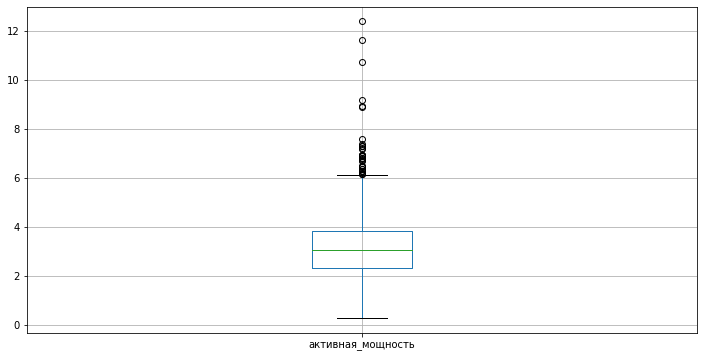

--------------------------------- Графики для реактивная_мощность ---------------------------------


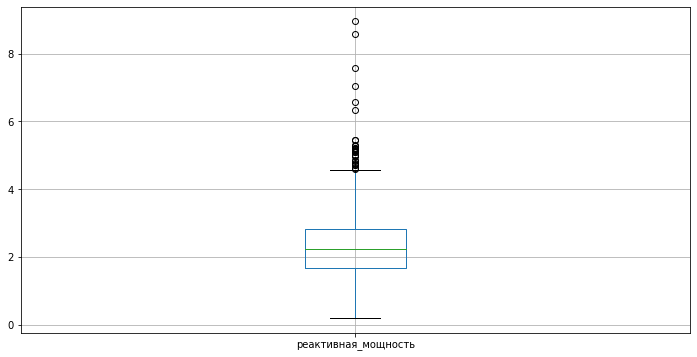

--------------------------------- Графики для газ_1 ---------------------------------


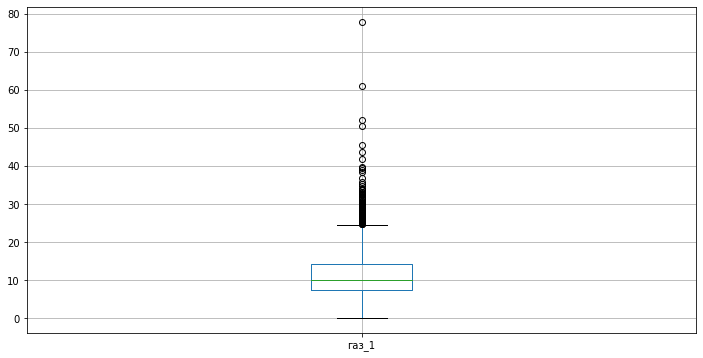

--------------------------------- Графики для начальная_температура ---------------------------------


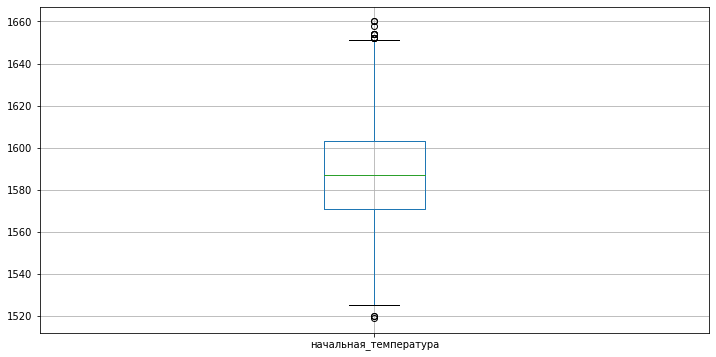

--------------------------------- Графики для время_замера ---------------------------------


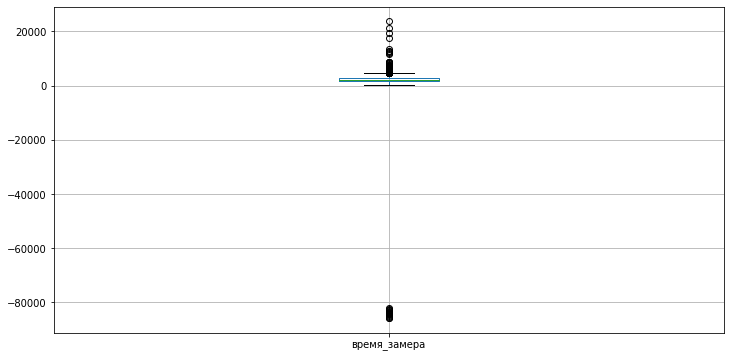

--------------------------------- Графики для температура ---------------------------------


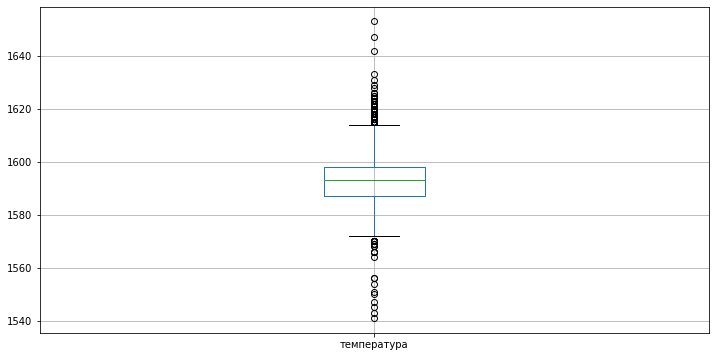

--------------------------------- Графики для длительность_нагрева ---------------------------------


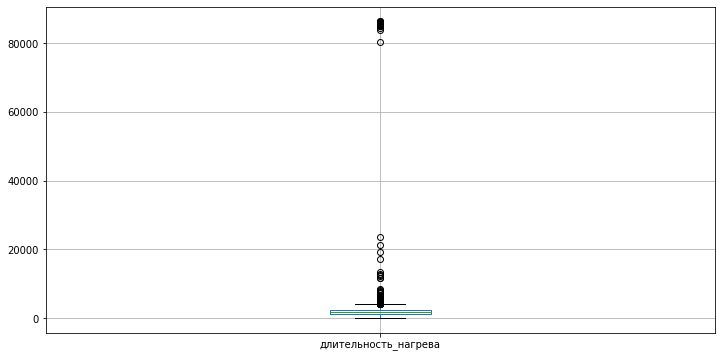

--------------------------------- Графики для полная_мощность ---------------------------------


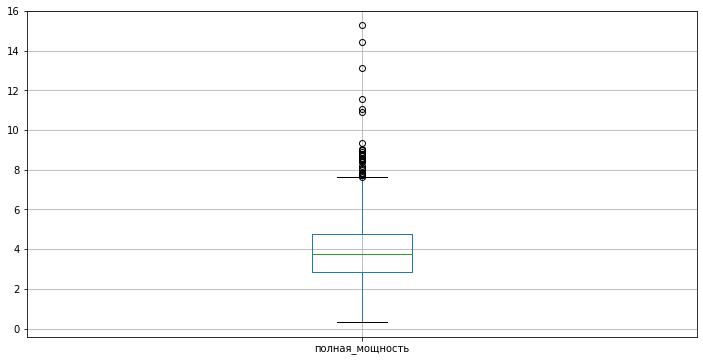

--------------------------------- data_bulk_x ---------------------------------


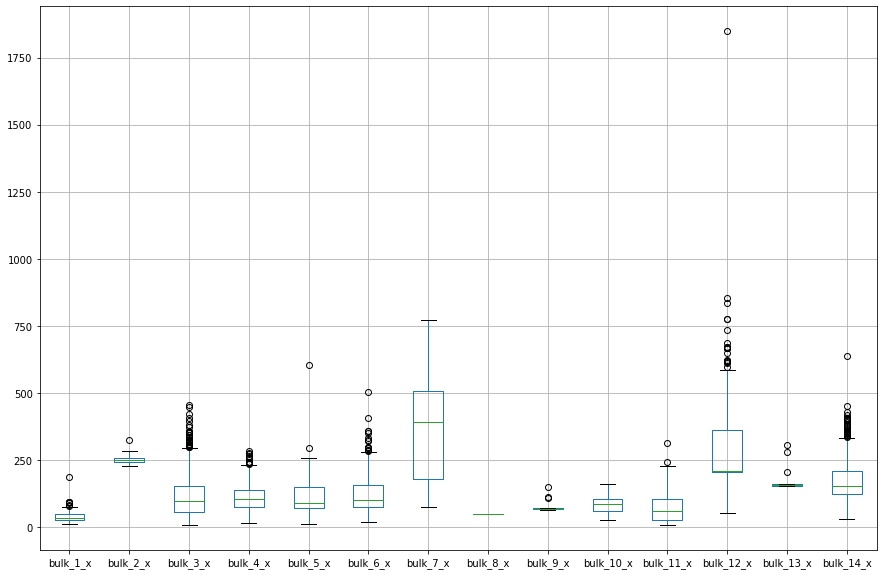

--------------------------------- data_bulk_y ---------------------------------


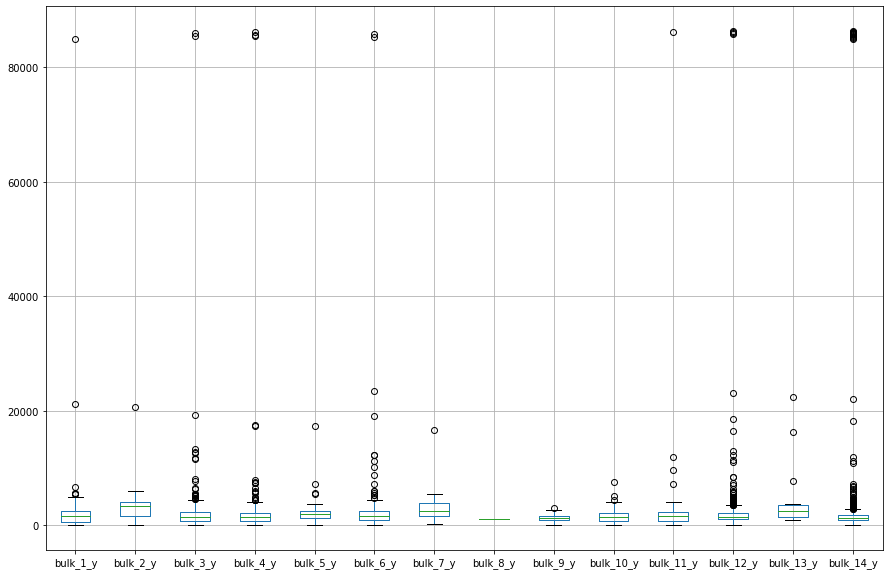

--------------------------------- data_wire_x ---------------------------------


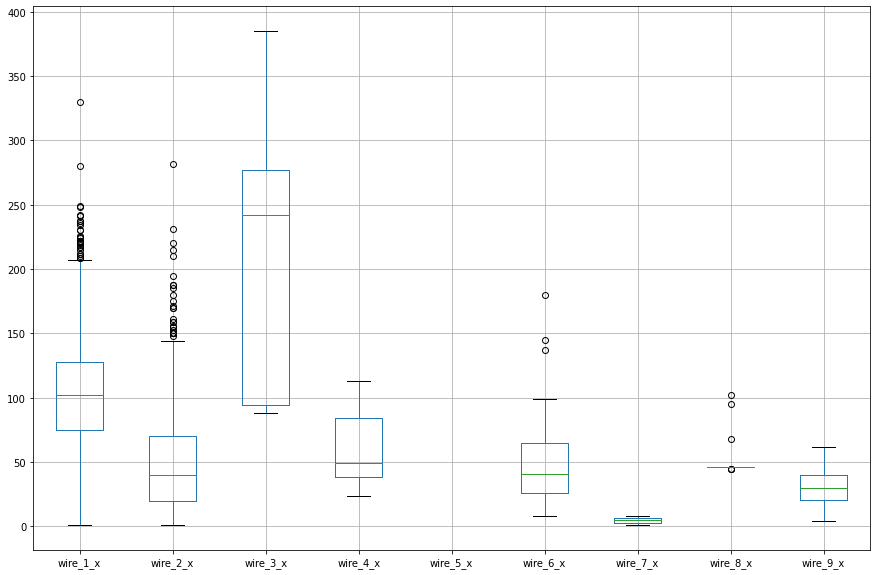

--------------------------------- data_wire_y ---------------------------------


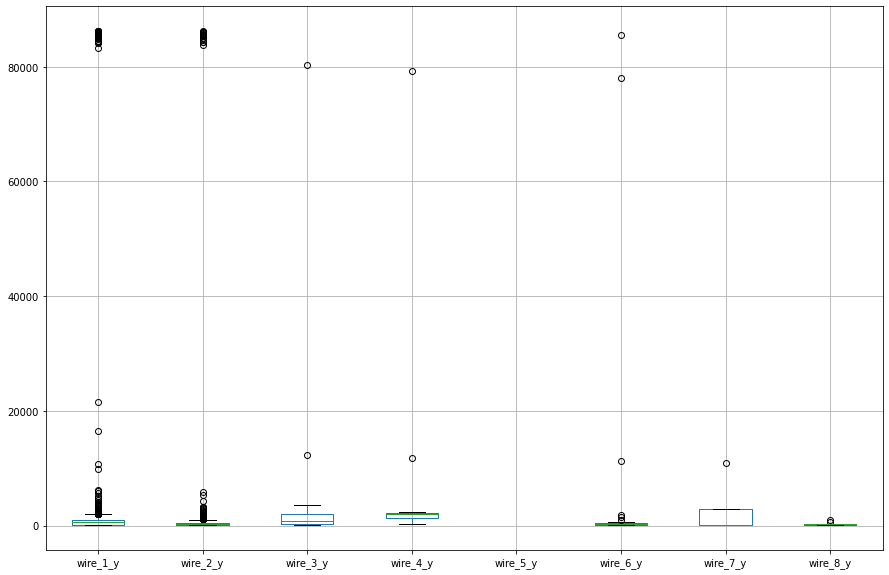

In [26]:
columns = ['активная_мощность', 'реактивная_мощность', 'газ_1', 'начальная_температура', 'время_замера', 'температура', 'длительность_нагрева', 'полная_мощность']

for column in columns:
    print(f'--------------------------------- Графики для {column} ---------------------------------')
    plt.figure(figsize=(12, 6))
    data.boxplot(column, figsize=(10, 8))
    plt.show()

data_bulk_x = data.iloc[:, 3:17]
data_bulk_y = data.iloc[:, 18:32]
data_wire_x = data.iloc[:, 37:46]
data_wire_y = data.iloc[:, 46:54]

print(f'--------------------------------- data_bulk_x ---------------------------------')
data_bulk_x.boxplot(figsize=(15, 10))
plt.show();
print(f'--------------------------------- data_bulk_y ---------------------------------')
data_bulk_y.boxplot(figsize=(15, 10))
plt.show();
print(f'--------------------------------- data_wire_x ---------------------------------')
data_wire_x.boxplot(figsize=(15, 10))
plt.show();
print(f'--------------------------------- data_wire_y ---------------------------------')
data_wire_y.boxplot(figsize=(15, 10))
plt.show();

У активной мощности есть выбросы, но нет аномальных значей, что хорошо. Для трен выборки нужно будет удалить значения больше 6.  
реактивная_мощность. Аномалий нет. Выбросы с 5.  
газ_1. Есть выбросы с 25.
начальная_температура. Можно будет не удалять выбросы.  
время_замера. А вот тут кажется есть значения меньше 0. Их нужно удалить и посмотреть ящик поближе. Это должны быть переходы между днями, так как разность начиналась с 0 из-за этого. 
температура. Выбросы с 1620 и до 1560.  
длительность_нагрева. Обнаружены аномалии с 70000. Разберемся с этим ниже.  
полная_мощность. Аномалий нет. Можно будет удалить для трен выборки значения больше 10.  
У bulk тоже есть выбросы и даже некоторые аномалии. Удалим их ниже.
data_bulk_y. Ну и как раньше мы могли заметить большие значения времени. Тут они тоже присутствуют. Скорее всего мы их уже удалили, но лучшке будет проверить.  
wire_x в целом имеет только статические выбросы.  
У data_wire_y тоже есть проблема со значениями выше 80000

In [27]:
# запишем длину датафрейма до исключения аномалий
len_data_1 = len(data)
q = data[data['время_замера'] < 0]
q['время_замера']

79     -84812
146    -84054
172    -83387
194    -83721
218    -82713
606    -84300
848    -82852
944    -84192
999    -83539
1026   -85710
1270   -82098
1838   -82277
1910   -85289
1977   -84561
2066   -83095
2290   -85574
Name: время_замера, dtype: int64

Таких данных оказалось мало, поэтому их можно благополучно дропнуть

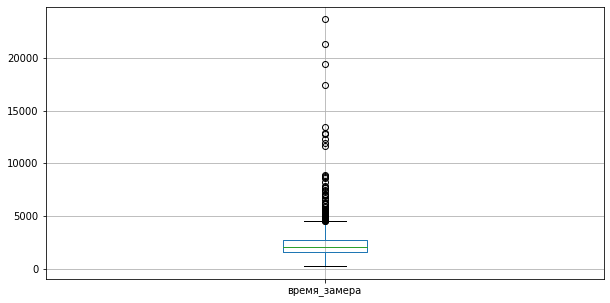

In [28]:
data = data[data['время_замера'] > 0]
data.boxplot('время_замера', figsize=(10, 5));

На всякий случай удалим еще значения больше 15000. Остальное нормально

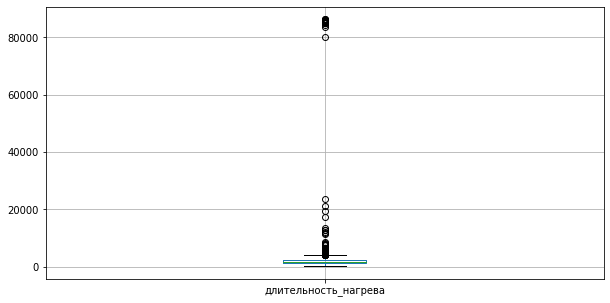

In [29]:
data.boxplot('длительность_нагрева', figsize=(10, 5));

Получился достаточно большой разброс. Сейчас мы ничего удалять не будем, а оставим для тренировочной выборки - выбросы больше 6000

In [30]:
data.fillna(0, inplace=True)
data.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,key,активная_мощность,реактивная_мощность,bulk_1_x,bulk_2_x,bulk_3_x,bulk_4_x,bulk_5_x,bulk_6_x,bulk_7_x,...,wire_2_y,wire_3_y,wire_4_y,wire_5_y,wire_6_y,wire_7_y,wire_8_y,wire_9_y,длительность_нагрева,полная_мощность
0,1,3.036730,2.142821,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1583,3.716640
1,2,2.139408,1.453357,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1144,2.586370
2,3,4.063641,2.937457,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1525,5.014163
3,4,2.706489,2.056992,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1093,3.399456
4,5,2.252950,1.687991,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1362,2.815155


In [31]:
data = data[(data['wire_1_y'] < 6000)]

In [32]:
len_data_2 = len(data)
print(len_data_1 - len_data_2)

56


Мы повторно удалили все аномалии из таблицы data. Их оказалось 56. Были отрицательные значения в признаке 'время_замера', которые конечно же мы удалили. Для анализа пришлось нули поменять на None, чтобы можно было посмотреть на выделяющиеся значения. Затем мы все вернули обратно. Выбросов очень много и их мы будем удалять после деления датасета на тренировочную и тестовую выборки.

Перейдем к кореляционному анализу. Признаки bulk и wire сами по себе очень похожи, поэтому мы можем взять для анализа всего по паре, чтобы не было каши. Будем использовать метод Пирсона, так как он хорошо подходит для числовых переменных переменных, которые у нас и есть, и определяет линейные зависимости

In [33]:
columns = ['активная_мощность', 'реактивная_мощность', 'газ_1', 'начальная_температура', 'время_замера', 'температура',
           'длительность_нагрева', 'полная_мощность', 'bulk_1_x', 'bulk_2_x', 'bulk_1_y', 'bulk_2_y', 'wire_1_x', 'wire_2_x', 
          'wire_1_y', 'wire_2_y']
data_analiz = data[columns]
data_analiz.head()

,активная_мощность,реактивная_мощность,газ_1,начальная_температура,время_замера,температура,длительность_нагрева,полная_мощность,bulk_1_x,bulk_2_x,bulk_1_y,bulk_2_y,wire_1_x,wire_2_x,wire_1_y,wire_2_y
0,3.036730,2.142821,29.749987,1571,1704,1613,1583,3.716640,0.0,0.0,0.0,0.0,60.0,0.0,245.0,0.0
1,2.139408,1.453357,12.555561,1581,1255,1602,1144,2.586370,0.0,0.0,0.0,0.0,96.0,0.0,156.0,0.0
2,4.063641,2.937457,28.554792,1596,1743,1599,1525,5.014163,0.0,0.0,0.0,0.0,91.0,0.0,292.0,0.0
3,2.706489,2.056992,18.841219,1601,1210,1625,1093,3.399456,0.0,0.0,0.0,0.0,89.0,0.0,225.0,0.0
4,2.252950,1.687991,5.413692,1576,1526,1602,1362,2.815155,0.0,0.0,0.0,0.0,89.0,9.0,571.0,261.0


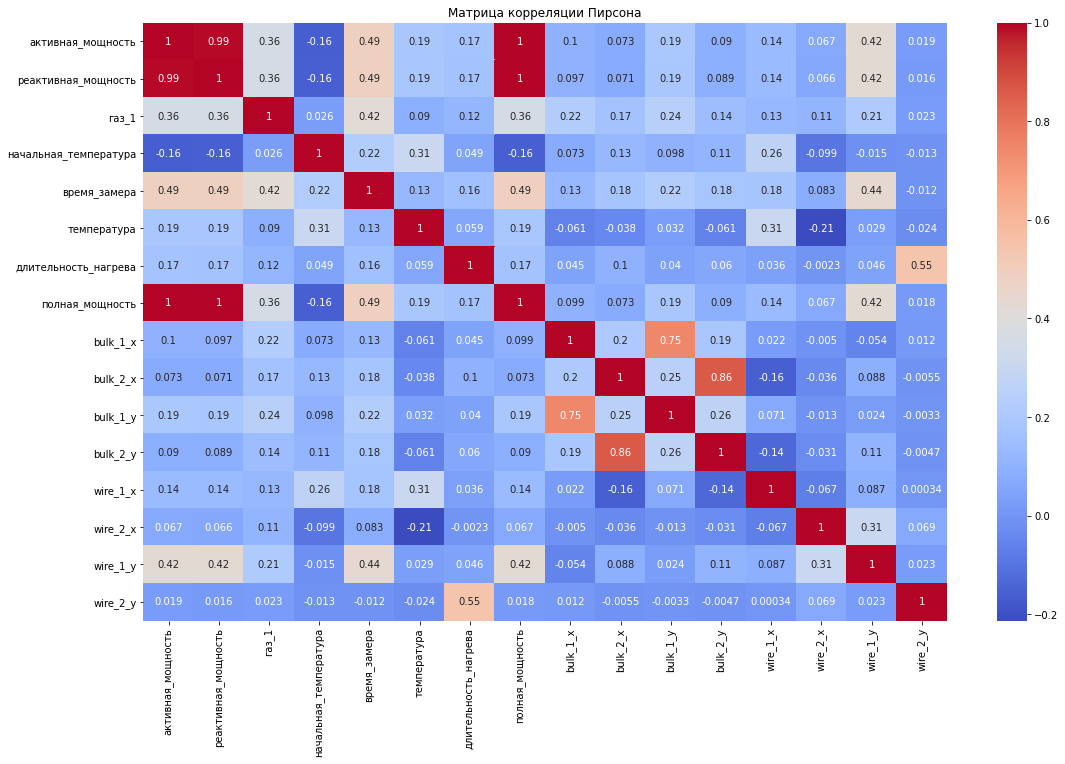

In [34]:
correlation_matrix = data_analiz.corr(method='pearson')
plt.figure(figsize=(18, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Пирсона')
plt.show()

Все-таки мощности между собой слишком сильно коррелируют, поэтому лучше всего будет оставить только общую мощность.  
У газа сильной корреляции ни с кем нет.  
Начальная температура получилась достаточно сомнительным признаком, который особо не влияет или противоположно влияет на другие, а на некторые вообще нет. Но она хорошо зависит с целевым признаком, что очень хорошо, поэтому оставим.
Время замера показало себя очень хорошо. Только с длительностью нагрева получается очень сильная связь из-за которой возможна даже мультиколлинеарность, но пока тоже оставим этот признак.  
Целевой признак температуры оказался не таким зависимым от всех остальных признаков, что не очень хорошо. У мощностей такой маленьки показатель видимо из-за их мультиколлинеарности. Хорогие результаты показали начальная температура и wire_1_x.  
Длительность нагрева хорошо коррелирует с остальными признаками.  
Полная мощность тоже показала хорошие результаты.  
Дальше идут примеси. Большинство из них показали плохие результаты корреляции. Стоит задуматься об их удалении, чтобы они не мешали модели обучаться. Если посмотреть, то коэффициенты примесей зависят от того сколько у них в данных пропусков, что достаточно логично, поэтому данные, которые будут иметь очень много пропусков, можно спокойно удалять. Это bulk 2, 7, 8, 9, 13. У wire это 4, 5, 7, 8, 9.  
А пока удалим активную и реактивную мощности

In [35]:
data = data.drop(['активная_мощность', 'реактивная_мощность'], axis = 1)
data = data.drop(['bulk_2_x', 'bulk_7_x', 'bulk_8_x', 'bulk_9_x', 'bulk_13_x',
                  'bulk_2_y', 'bulk_7_y', 'bulk_8_y', 'bulk_9_y', 'bulk_13_y',
                 'wire_4_x', 'wire_5_x', 'wire_7_x', 'wire_8_x', 'wire_9_x',
                  'wire_4_y', 'wire_5_y', 'wire_7_y', 'wire_8_y', 'wire_9_y',], axis = 1)
data

,key,bulk_1_x,bulk_3_x,bulk_4_x,bulk_5_x,bulk_6_x,bulk_10_x,bulk_11_x,bulk_12_x,bulk_14_x,...,wire_1_x,wire_2_x,wire_3_x,wire_6_x,wire_1_y,wire_2_y,wire_3_y,wire_6_y,длительность_нагрева,полная_мощность
0,1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,...,60.0,0.0,0.0,0.0,245.0,0.0,0.0,0.0,1583,3.716640
1,2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,...,96.0,0.0,0.0,0.0,156.0,0.0,0.0,0.0,1144,2.586370
2,3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,...,91.0,0.0,0.0,0.0,292.0,0.0,0.0,0.0,1525,5.014163
3,4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,...,89.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,1093,3.399456
4,5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,...,89.0,9.0,0.0,0.0,571.0,261.0,0.0,0.0,1362,2.815155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,0.0,21.0,0.0,0.0,0.0,90.0,0.0,256.0,129.0,...,89.0,0.0,0.0,0.0,223.0,0.0,0.0,0.0,1208,3.863328
2325,2496,0.0,0.0,63.0,0.0,0.0,122.0,0.0,256.0,129.0,...,114.0,0.0,0.0,0.0,132.0,0.0,0.0,0.0,1569,5.067396
2326,2497,0.0,0.0,85.0,0.0,0.0,0.0,0.0,230.0,124.0,...,94.0,9.0,0.0,0.0,514.0,174.0,0.0,0.0,824,4.360104
2327,2498,0.0,90.0,0.0,0.0,0.0,101.0,0.0,206.0,129.0,...,118.0,0.0,0.0,0.0,273.0,0.0,0.0,0.0,1358,3.907887


Получился объемный шаг, в котором мы выполнили предобработку и повторный анализ всех наших данных, которые объединили в один датафрейм. Было замечено много выбросов практически во всех признаках они присутствовали, где-то не сильные, а где-то достаточно далекие от других, чтобы можно было такое удалять для тренировочных данных. Ну и конечно же были аномальные выбросы около 50 штук, которые были успешно удалены. В корреляционном анализе использовался метод Пирсона, с помощью которого была построена матрица корреляции. Мощности слишком сильно коррелировали друг с другом, поэтому активную и реактивную пришлось удалить. Такие признаки как: газ, начальная температура, время замера, длительность нагрева и полная мощность показали себя хорошо по коэффициентам корреляции. Целевой признак не очень порадовал, так как имеет не такие сильные связи с остальными. Примесные материалы тоже не дали хороших результатов, что достаточно логично, так как их много, поэтому было решено остваить только лучшие, где было не так много пропусков по сравнению с остальными.

## Подготовка данных для модели

На данном шаге нам предстоит разделить данные на две выборки - тренировочную и тестовую в соотношении 3 к 1. Помимо этого нужно будет удалить выбросы из тренировочных данных по просьбе заказчика.  
Для начала разделим выборки, чтобы можно было поработать с выбросами.

In [36]:
RANDOM_STATE = 60524
TEST_SIZE=0.25

X = data.drop('температура', axis = 1)
y = data['температура']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE, test_size = TEST_SIZE)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1704, 34)
(569, 34)
(1704,)
(569,)


Объединим таблицы, чтобы с ними можно было работать и сразу же вместо 0 поставим пропуски

In [37]:
X_y_train = X_train.join(y_train).reset_index(drop=True)
X_y_train = X_y_train.replace(0, np.nan)
len_X_y_train_1 = len(X_y_train)
X_y_train.head()

,key,bulk_1_x,bulk_3_x,bulk_4_x,bulk_5_x,bulk_6_x,bulk_10_x,bulk_11_x,bulk_12_x,bulk_14_x,...,wire_2_x,wire_3_x,wire_6_x,wire_1_y,wire_2_y,wire_3_y,wire_6_y,длительность_нагрева,полная_мощность,температура
0,2414,NaN,53.0,NaN,NaN,NaN,NaN,NaN,153.0,128.0,...,NaN,NaN,NaN,118.0,NaN,NaN,NaN,1278,1.925419,1589
1,837,NaN,157.0,NaN,NaN,NaN,NaN,NaN,409.0,202.0,...,92.0,NaN,NaN,724.0,481.0,NaN,NaN,2958,4.248379,1615
2,2023,NaN,NaN,NaN,NaN,111.0,NaN,18.0,NaN,252.0,...,36.0,NaN,NaN,NaN,143.0,NaN,NaN,1092,2.333594,1581
3,1219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.0,...,NaN,NaN,NaN,1239.0,NaN,NaN,NaN,1534,3.333430,1591
4,1770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,102.0,...,NaN,NaN,NaN,192.0,NaN,NaN,NaN,1431,3.687462,1595


In [38]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    1704 non-null   int64  
 1   bulk_1_x               148 non-null    float64
 2   bulk_3_x               714 non-null    float64
 3   bulk_4_x               586 non-null    float64
 4   bulk_5_x               39 non-null     float64
 5   bulk_6_x               314 non-null    float64
 6   bulk_10_x              106 non-null    float64
 7   bulk_11_x              96 non-null     float64
 8   bulk_12_x              1337 non-null   float64
 9   bulk_14_x              1519 non-null   float64
 10  bulk_15_x              1250 non-null   float64
 11  bulk_1_y               148 non-null    float64
 12  bulk_3_y               714 non-null    float64
 13  bulk_4_y               586 non-null    float64
 14  bulk_5_y               39 non-null     float64
 15  bulk

--------------------------------- Графики для газ_1 ---------------------------------


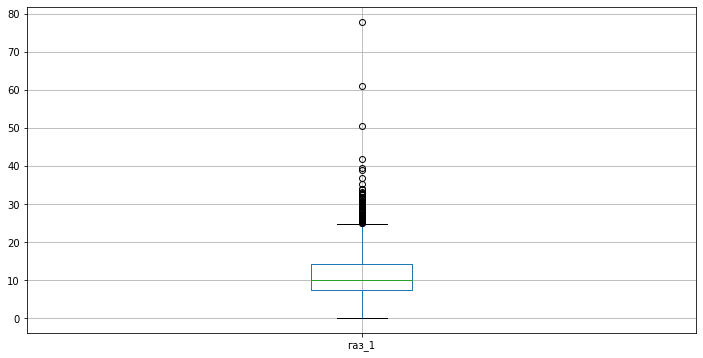

--------------------------------- Графики для начальная_температура ---------------------------------


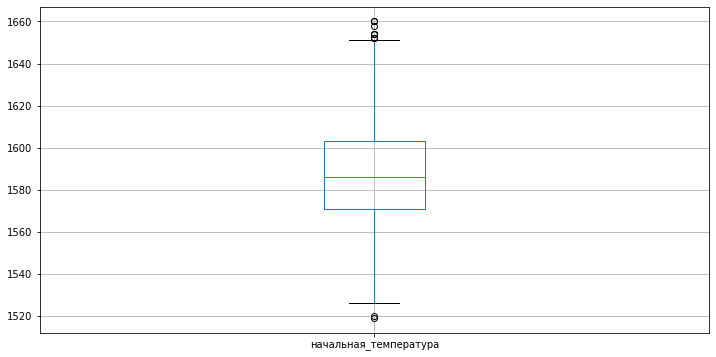

--------------------------------- Графики для время_замера ---------------------------------


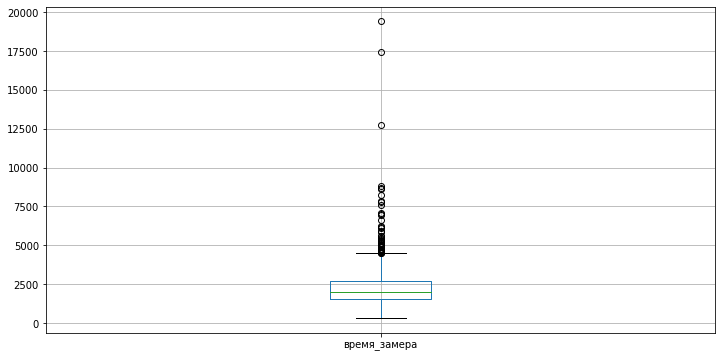

--------------------------------- Графики для температура ---------------------------------


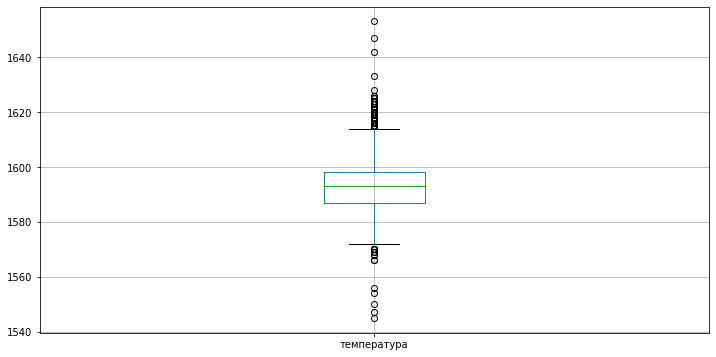

--------------------------------- Графики для длительность_нагрева ---------------------------------


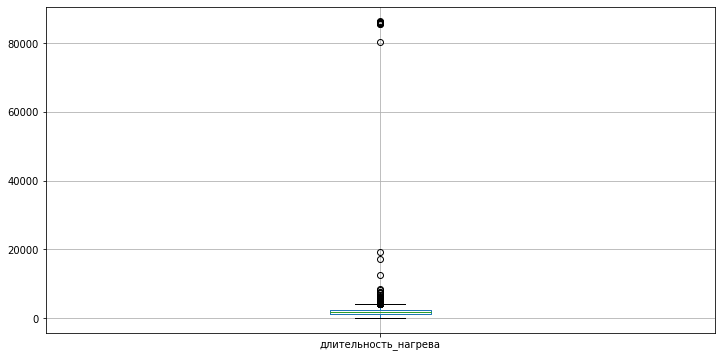

--------------------------------- Графики для полная_мощность ---------------------------------


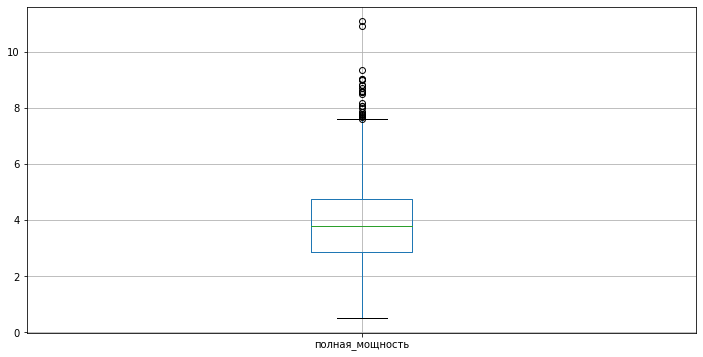

--------------------------------- X_y_train_bulk_x ---------------------------------


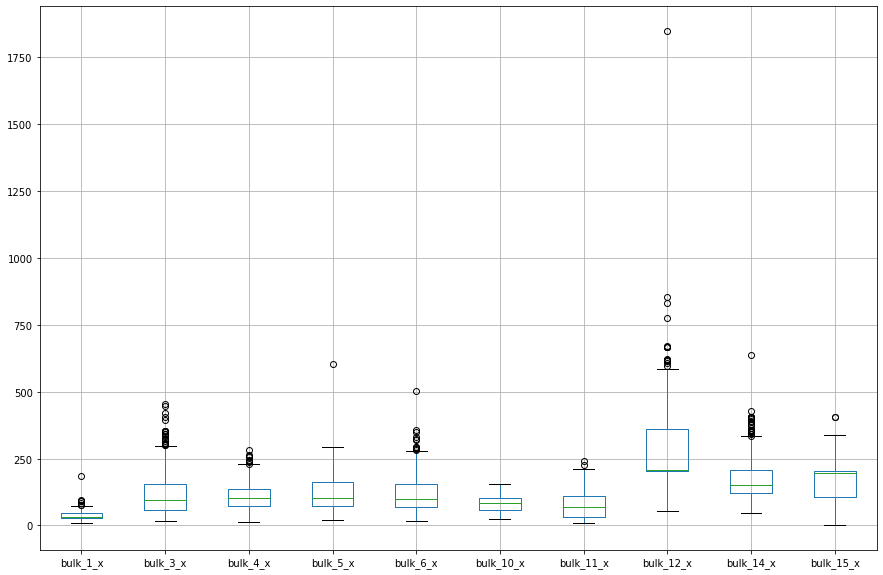

--------------------------------- X_y_train_bulk_y ---------------------------------


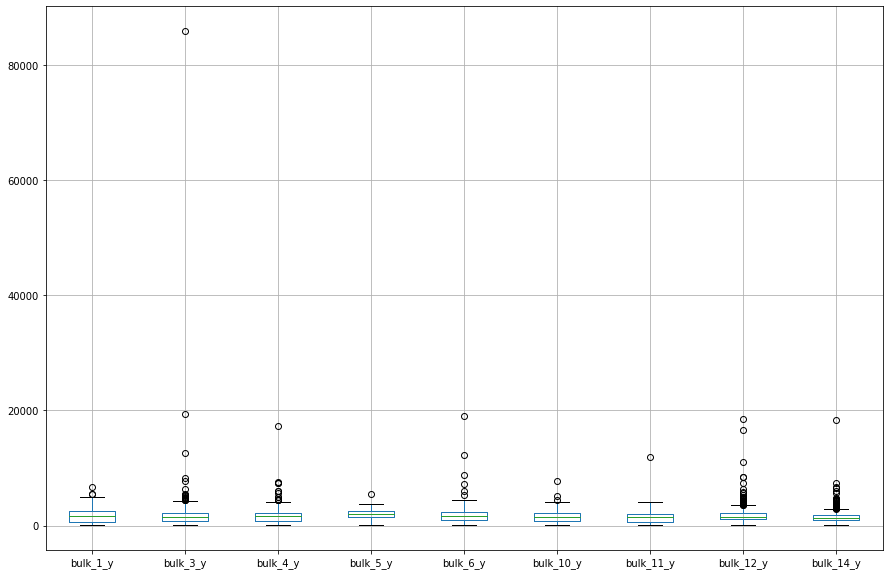

--------------------------------- X_y_train_wire_x ---------------------------------


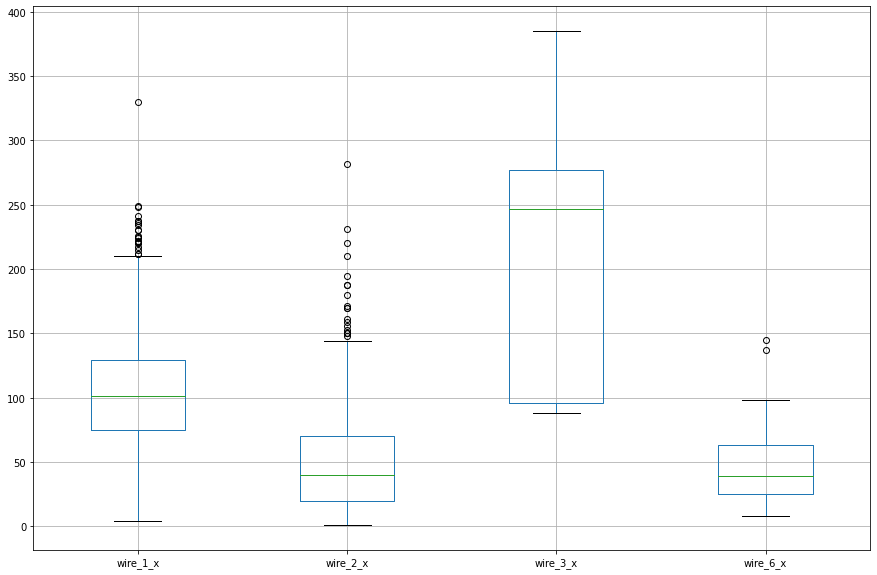

--------------------------------- X_y_train_wire_y ---------------------------------


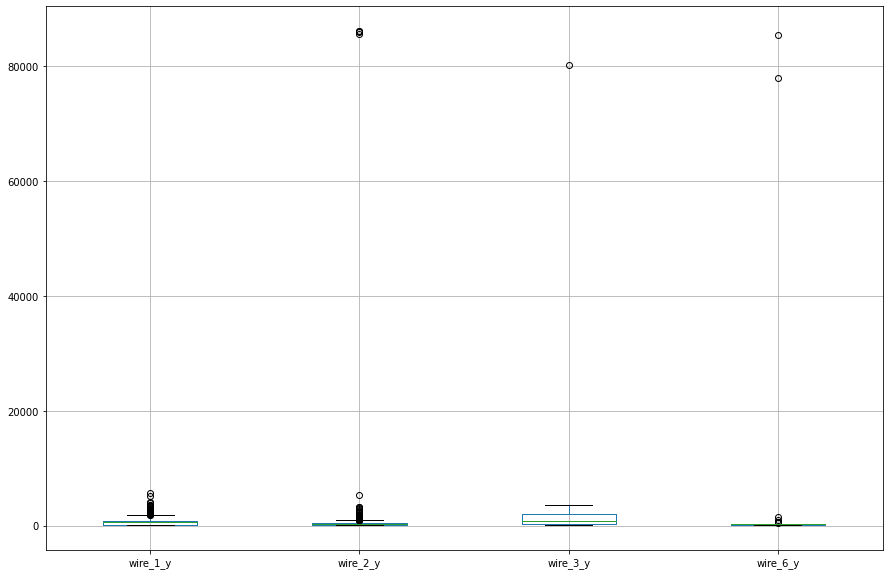

In [39]:
columns = ['газ_1', 'начальная_температура', 'время_замера', 'температура', 'длительность_нагрева', 'полная_мощность']

for column in columns:
    print(f'--------------------------------- Графики для {column} ---------------------------------')
    plt.figure(figsize=(12, 6))
    X_y_train.boxplot(column, figsize=(10, 8))
    plt.show()

X_y_train_bulk_x = X_y_train.iloc[:, 1:11]
X_y_train_bulk_y = X_y_train.iloc[:, 11:20]
X_y_train_wire_x = X_y_train.iloc[:, 24:28]
X_y_train_wire_y = X_y_train.iloc[:, 28:32]

print(f'--------------------------------- X_y_train_bulk_x ---------------------------------')
X_y_train_bulk_x.boxplot(figsize=(15, 10))
plt.show();
print(f'--------------------------------- X_y_train_bulk_y ---------------------------------')
X_y_train_bulk_y.boxplot(figsize=(15, 10))
plt.show();
print(f'--------------------------------- X_y_train_wire_x ---------------------------------')
X_y_train_wire_x.boxplot(figsize=(15, 10))
plt.show();
print(f'--------------------------------- X_y_train_wire_y ---------------------------------')
X_y_train_wire_y.boxplot(figsize=(15, 10))
plt.show();

Вернем нолики на базу и начнем удалять выбросы

In [40]:
X_y_train.fillna(0, inplace=True)
X_y_train.head()

,key,bulk_1_x,bulk_3_x,bulk_4_x,bulk_5_x,bulk_6_x,bulk_10_x,bulk_11_x,bulk_12_x,bulk_14_x,...,wire_2_x,wire_3_x,wire_6_x,wire_1_y,wire_2_y,wire_3_y,wire_6_y,длительность_нагрева,полная_мощность,температура
0,2414,0.0,53.0,0.0,0.0,0.0,0.0,0.0,153.0,128.0,...,0.0,0.0,0.0,118.0,0.0,0.0,0.0,1278,1.925419,1589
1,837,0.0,157.0,0.0,0.0,0.0,0.0,0.0,409.0,202.0,...,92.0,0.0,0.0,724.0,481.0,0.0,0.0,2958,4.248379,1615
2,2023,0.0,0.0,0.0,0.0,111.0,0.0,18.0,0.0,252.0,...,36.0,0.0,0.0,0.0,143.0,0.0,0.0,1092,2.333594,1581
3,1219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,153.0,...,0.0,0.0,0.0,1239.0,0.0,0.0,0.0,1534,3.333430,1591
4,1770,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,102.0,...,0.0,0.0,0.0,192.0,0.0,0.0,0.0,1431,3.687462,1595


In [41]:
X_y_train = X_y_train[X_y_train['газ_1'] < 28]
X_y_train = X_y_train[X_y_train['начальная_температура'] < 1650]
X_y_train = X_y_train[X_y_train['время_замера'] < 5000]
X_y_train = X_y_train[X_y_train['длительность_нагрева'] < 4000]
X_y_train = X_y_train[X_y_train['полная_мощность'] < 7.8]

X_y_train = X_y_train[X_y_train['bulk_3_x'] < 310]
X_y_train = X_y_train[X_y_train['bulk_4_x'] < 230]
X_y_train = X_y_train[X_y_train['bulk_6_x'] < 300]
X_y_train = X_y_train[X_y_train['bulk_12_x'] < 580]
X_y_train = X_y_train[X_y_train['bulk_14_x'] < 360]
X_y_train = X_y_train[X_y_train['bulk_15_x'] < 400]

X_y_train = X_y_train[X_y_train['bulk_1_y'] < 5000]
X_y_train = X_y_train[X_y_train['bulk_3_y'] < 4600]
X_y_train = X_y_train[X_y_train['bulk_4_y'] < 4300]
X_y_train = X_y_train[X_y_train['bulk_5_y'] < 4000]
X_y_train = X_y_train[X_y_train['bulk_6_y'] < 4500]
X_y_train = X_y_train[X_y_train['bulk_10_y'] < 5000]
X_y_train = X_y_train[X_y_train['bulk_11_y'] < 4300]
X_y_train = X_y_train[X_y_train['bulk_12_y'] < 3900]
X_y_train = X_y_train[X_y_train['bulk_14_y'] < 3300]

X_y_train = X_y_train[X_y_train['wire_1_x'] < 210]
X_y_train = X_y_train[X_y_train['wire_3_x'] <= 150]
X_y_train = X_y_train[X_y_train['wire_6_x'] <= 100]

X_y_train = X_y_train[X_y_train['wire_1_y'] <= 2000]
X_y_train = X_y_train[X_y_train['wire_2_y'] <= 1000]
X_y_train = X_y_train[X_y_train['wire_3_y'] <= 3000]
X_y_train = X_y_train[X_y_train['wire_6_y'] <= 500]


X_y_train.shape

(1454, 35)

In [42]:
len_X_y_train_2 = len(X_y_train)
print(len_X_y_train_1 - len_X_y_train_2)

250


250 выбросов нам удалось убрать из 1700 данных в тренировочной выборке. Осталось снова разделить целевой признак от входящего и можно масштабировать

In [43]:
X_train = X_y_train.drop(['температура', 'key'], axis = 1)
X_test = X_test.drop('key', axis = 1)
y_train = X_y_train['температура']
print(X_train.shape)
print(y_train.shape)

(1454, 33)
(1454,)


In [44]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Отлично! На данном шаге мы произвели заключающую предобработку данных. Она была сделана для обучающей выборки, где мы строили только ящики с усами, так как нам были интересны только выбросы. Таким образом мы удалили 227 выбросов, которые могли бы помешать обучению модели. Затем с помощью MinMaxScaler масштабировали тренировочную и тестовую выборки. Осталось обучить и найти лучшую модель для нашей задачи.

## Обучение моделей

На данном шаге мы планируем с помощью GridSearchCV обучить несколько моделей с перебором гиперпараметров, из которых найдем лучшую и будем проверять ее на заключительной тестовой выборке. Масштабирование было сделано с помощью MinMaxScaler. Результат будет анализировать с помощью метрики MAE.  
Начнем с обучения линейной регрессии.

In [45]:
model = LinearRegression()

param_grid = {
}

gs = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
gs.fit(X_train_scaled, y_train)
predictions = gs.predict(X_train_scaled)

best_mae_1 = -gs.best_score_
print(best_mae_1)

6.580156391434019


Получили отличную метрику MAE = 6.5, что очень даже неплохо. Выборку делили на 5 валидационных с помощью сv = 5.  
Посмотрим теперь на модель под названием дерево решений. Какой результат она покажет на наших тренировочных данных, если ей задать перебор параметров

In [46]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid = {
    'max_depth': [5, 10, 30],
    'min_samples_split': [30, 70, 100],
    'min_samples_leaf': [10, 20]
}
gs = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train_scaled, y_train)
predictions = gs.predict(X_train_scaled)

best_model = gs.best_estimator_
print(best_model)
best_mae_2 = -gs.best_score_
print(best_mae_2)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=30,
                      random_state=60524)
7.29857090405321


Метрика получилась хуже чем у линейной регрессии MAE = 7.3. Лучшие параметры получились такие: max_depth=5, min_samples_leaf=10, min_samples_split=100,  random_state=6052.  
Давайте посмотрим на еще одну модель - градиентный бустинг. У нее тоже будем перебирать гиперпараметры и кол-во валидационных выборок сделаем также 3 штуки. Результат должен получиться хорошим.

In [47]:
model = LGBMRegressor(seed=RANDOM_STATE, verbosity=-1)
param_grid = {
    'n_estimators': [10, 40],
    'max_depth': [3, 5, 20],
    'num_leaves': [10, 30, 60]
}
gs = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train_scaled, y_train)
predictions = gs.predict(X_train_scaled)

best_model = gs.best_estimator_
print(best_model)
best_mae_3 = -gs.best_score_
print(best_mae_3)


LGBMRegressor(max_depth=20, n_estimators=40, num_leaves=10, seed=60524,
              verbosity=-1)
6.447677774666949


MAE = 6.44. Это пока лучший результат из всех прошлых моделей. Гипермапаметры получились такими: max_depth=20, n_estimators=40, num_leaves=10, seed=60524, verbosity=-1.  
У нас все до этого модели обучались очень быстро, поэтому можно попробовать достаточно редко используемую модель из-за ее скорости обучения это метод опорных векторов. Тоже будем перебирать гиперпараметры и посмотрим какой результат она покажет

In [48]:
param_grid = {'C': [0.1, 1, 100], 'gamma': [0.1, 0.01], 'kernel': ['rbf', 'linear', 'poly']}
model = SVC()
gs = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train_scaled, y_train)
predictions = gs.predict(X_train_scaled)

best_model = gs.best_estimator_
print(best_model)
best_mae_4 = -gs.best_score_
print(best_mae_4)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


SVC(C=1, gamma=0.1, kernel='linear')
7.08522052767601


К сожалению модель SVC не оправддала наших ожиданий, показав худшую метрику по сравнению со всеми моделями.  
Создадим итоговую таблицу для моделей и их метрик на тренировочной выборке

In [49]:
w = ['модель', 'метрика MAE']
q = [['LinearRegressoin', best_mae_1], ['DecisionTreeRegressor', best_mae_2], ['LGBMRegressor', best_mae_3], ['SVC', best_mae_4]]
itogi = pd.DataFrame(data = q, columns = w)
itogi = itogi.sort_values(by='метрика MAE', ascending=True)
itogi

,модель,метрика MAE
2,LGBMRegressor,6.447678
0,LinearRegressoin,6.580156
3,SVC,7.085221
1,DecisionTreeRegressor,7.298571


Лучшей моделью оказался градиентный бустинг, показав метрику MAE = 6.33. По сравнению с другими моделями это достаточно большой отрыв. Второе место заняла модель линейной регрессии с метрикой 6.5. Третье - SVC четвертое - дерево решений. Обе модели превысили значение 7.  
Теперь мы проверим лучшую модель на тестовой выборке. Результат должен оказаться меньше 6.8 по просьбе заказчика.

In [50]:
model = LGBMRegressor(seed=RANDOM_STATE, n_estimators=40, verbosity=-1, max_depth=5, num_leaves=30)
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, pred)
print(mae)

6.580178333233691


Отлично! Метрика получилась меньше 6.5, как и просил заказчик. Модель градиентного бустинга не подвела.
Но еше рано радоваться.

Давайте еще посмотрим на коэффициенты важности признаков, чтобы понять какие параметры больше влияли на результат модели

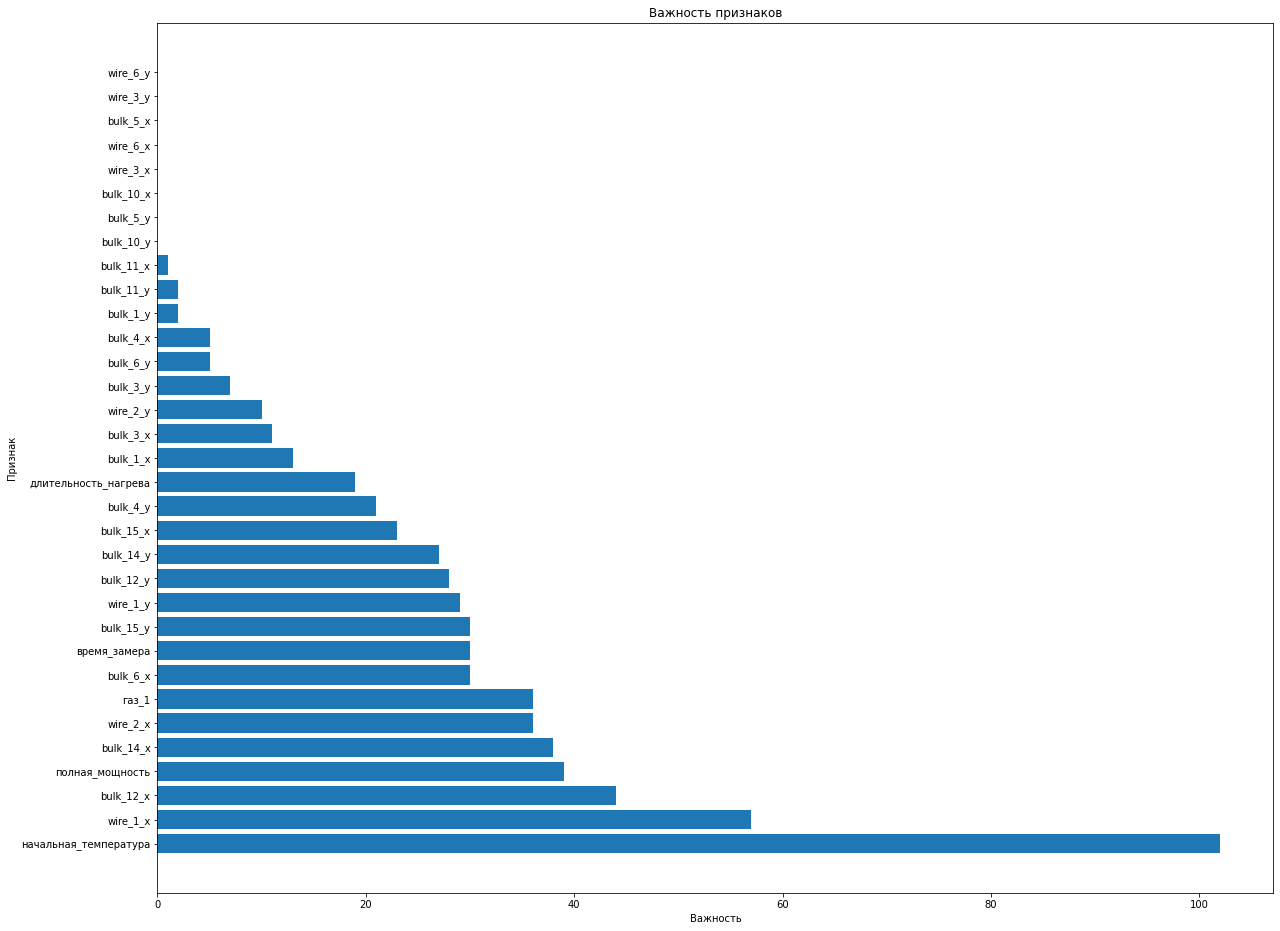

In [51]:
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Признак': X_train.columns, 'Важность': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Важность', ascending=False)
plt.figure(figsize=(20, 16))
plt.barh(feature_importance_df['Признак'][:33], feature_importance_df['Важность'][:33])
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.show()

По таблице важности признаков можно понять, что начальная температура сыграла ключевую роль для модели. Затем по порядку идут: wire_1_x, bulk_12_x, полная мощность, bulk_14_x, wire_2_x, газ, bulk_6_x, время замера и снова материалы. Меньше всего повлияли на итоговую температуру это материалы, у которых, наверное, было много пропусков или их очень малыми долями ддобавляли в сплав. Вдруг все наши усилия были напрасны? Давайте проверим нашу итоговую модель на результативность. Сравним ее со средними значениями тренировочной выборки с помощью DummyRegressor. Чьи результаты окажутся лучше?

In [52]:
mae_model = mae
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_train)
dummy_predictions = dummy_model.predict(X_test_scaled)
mae_dummy = mean_absolute_error(y_test, dummy_predictions)
print('MAE_dummy', mae_dummy)
if mae_model < mae_dummy:
    print("Победа нашей модельки!")
else:
    print("Победа константы(")

MAE_dummy 7.820672866560461
Победа нашей модельки!


Результаты получились очень интересными. Обычное предсказание средними значениями показало не такой и плохой результат. Казалось, что будет большая разница, а разрыв оказался не таким и большим. Но все равно наша модель градиентного бустинга оказалась лучше, что очень радует.

## Итоги проекта

Мы проделали очень большую работу, чтобы помочь оптимизировать производственные расходы, металлургическому комбинату «Стальная птица». С помощью данных, которые они нам предоставили, мы создали различные модели, решающие задачу регрессии, которые предсказывают итоговую температуру сплава, полученную после добавлений различных материалов. Это поможет производству экономить энергию на нагрев сплавов. Для создания таких моделей нам пришлось проделать длинный путь, состоящий из большого количества таких этапов как:  
* Загрузка данных. На данном шаге мы загрузили 7 таблиц с данными, которые нам предоставила компнания. Они содержали в себе информацию о различных признаках, таких как: начало/конец нагрева, активная/реактивная мощности, объемы и время лигированных веществ, количество газа, используемого для вывода серы из сплава, время замера и целевой признак с температурой, полученной у металла на выходе. Затем мы привели названия столбцов к нижнему регистру, чтобы в будущем на это не отвлекаться, и поверхностно осмотрели данные.
* Исследовательский анализ и предобработка данных. В этом нам помогли несколько функций: analiz и optimize_memory_usage. С помощью первой - мы отобразили много важной информации о всех таблицах. Вторая - помогла оптимизировать данные, чтобы они занимали меньше памяти и с ними можно было быстрее работать. В данных были обнаружены пропуски. Одни в целевом признаке, которые нужно было удалить. Хорошо, что их оказалось немного. Другие пропуски были из-за того, что не все материалы в партии были задействованы в сплаве, поэтому у них не было значений. Было решено заполнить их 0, что достаточно логично. Но некоторые столбцы имели настолько много пропусков, что в них не было видно особого смысла, что мы и взяли на заметку. При построении гистограмм и ящиков с усами мы каждый раз заменяли нули обратно на пропуски, чтобы они не забирали на себя много значений и не портили графики. В некоторых данных были обнароужены аномалии, которые были успешно удалены. Не обошлось без выбросоув. Они были практически во всех признаках, но мы не стали их удалять, так как заказчик попросил сделать это только с тренировочной выборкой.
* Объединение таблиц. Это оказался достаточно трудный этап, из-за того, что все данные, кроме двух таблиц, имели в каждой новой строке уникальный номер ключа, по которому нужно было объединить все таблицы в одну. Для этого мы перезаписали признаки в уникальные ключи и отобрали партии, в которых удалили все ключи с одним замеров промежуточной температуры. И только после этого сделали объединение с помощью merge по ключу с параметром how = 'inner' для добавления только тех ключей, где были все данные. У нас получилась таблица с большим количеством признаков 3020 на 58. После этого мы добавили новые признаки, как полная мощность, время замера и длительность нагрева. И удалили начало/конец нагрева дугой, так как с помощью разности во времени мы перешли к длительности. Это должно будет помочь нашей будущей модели. И в заключении данного этапа мы снова воспользовались функцией analiz, чтобы убедиться в правильности действий.
* Анализ и предобработка данных общего датафрейма. На данном шаге мы для удобства заменили пробелы в названиях столбцов на "_". После этого снова вернули пропуски вместо нулей для построения ящиков с усами. Это помогло сделать общий анализ таблицы и даже убрать некоторые аномалии. Обозначили примерные границы для выбросов, чтобы потом их обработать после разделения на выборки. Было удалено 72 аномалии. Затем провели корреляционный анализ с помощью матрицы корреляции методом Пирсона. Мощности слишком сильно коррелировали друг с другом, поэтому активную и реактивную пришлось удалить. Такие признаки как: газ, начальная температура, время замера, длительность нагрева и полная мощность показали себя хорошо по коэффициентам корреляции. Целевой признак не очень порадовал, так как имеет не такие сильные связи с остальными. Примесные материалы тоже не дали хороших результатов, что достаточно логично, так как их много, поэтому было решено остваить только лучшие, где было не так много пропусков по сравнению с остальными.
* Подготовка данных для модели. Это был заключительный этап обработки данных. Мы снова построили ящики с усами и на этот раз удалили выбросы предварительно поделив данные на тренировочные и тестовые в соотношении 3 к 1 с помощью train_test_split. Выбросы были практически во всех признаках. В итоге их получилось 250, а размер уже тренировочной выборки оказался 1454 на 33.
* Обучение моделей. С помощью GridSearchCV обучили несколько моделей с перебором гиперпараметров, из которых нашли лучшую и проверили ее на заключительной тестовой выборке. Масштабирование было сделано с помощью MinMaxScaler. Результат будет визуализировали с помощью метрики MAE. Моделью с наименьшей метрикой MAE оказался градиентный бустинг с метрикой на тренировочной выборке 6.4, а на тестовой - 6.5. Данный результат мы сравнили с моделью, которая просто предсказывала средним значеним температуру, и наша модель оказалась лучше. По таблице важности признаков можно понять, что начальная температура сыграла ключевую роль для модели. Затем по порядку идут: wire_1_x, bulk_12_x, полная мощность, bulk_14_x, wire_2_x, газ, bulk_6_x, время замера и снова материалы. Меньше всего повлияли на итоговую температуру это материалы, у которых, наверное, было много пропусков или их очень малыми долями ддобавляли в сплав.

Для решения задачи оптимизации производства мы бы посоветовали металлургическому комбинату «Стальная птица» использовать нашу модель градиентного бустинга с такими параметрами, как n_estimators=40, verbosity=-1, max_depth=5, num_leaves=30 для наилучшего результата. И обратить внимание на начальную температуру, так как она больше всех влияет на итоговую температуру. Еще можно последить за такими признаками: wire_1_x, bulk_12_x, полная мощность, bulk_14_x, wire_2_x, газ, bulk_6_x, время замера. Они идут в порядке убывания по значимости, но также играют достаточно важную роль.